# Projet 7 - Effectuez une prédiction de revenus

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import os.path as pth

import P7_03_OCR7 as OCR

from scipy.stats import t, shapiro, bartlett, levene, normaltest
from scipy.stats import ncf, zscore

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

sns.set(color_codes = True)

In [2]:
_FONTSIZE_ = 18
_FONTSIZETITLE_ = 24

## Préparation des données

In [3]:
df_raw = pd.read_csv('./Data/world_income_distribution.csv')
df_elasticity = pd.read_csv('./Data/GDIMMay2018.csv')
df_gini_raw = pd.read_csv('./Data/gini.csv')

## Donnée WID

### Vérification de l'income

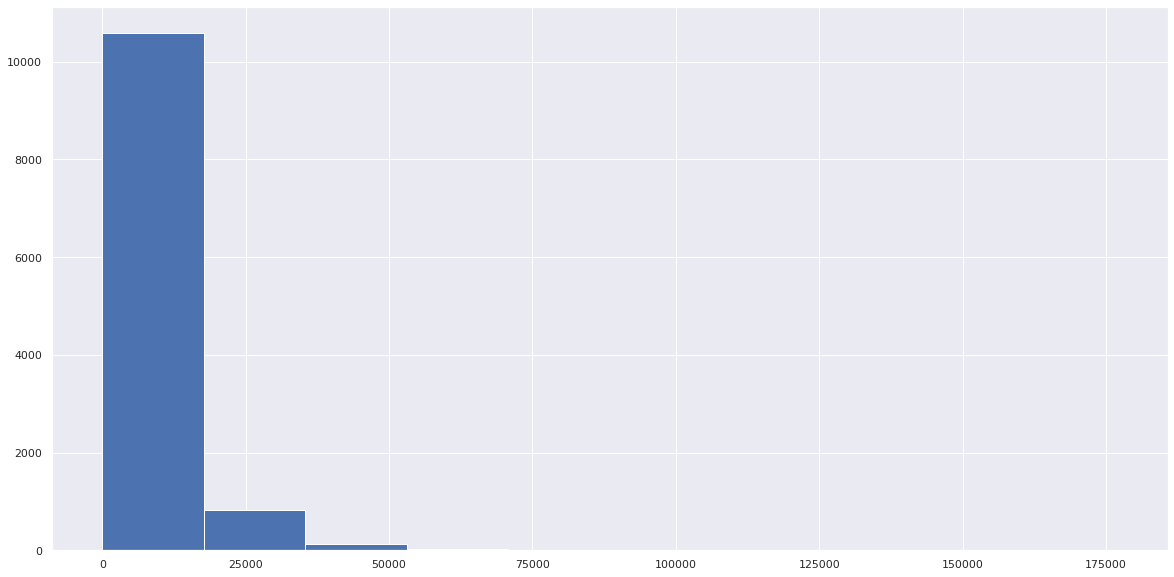

In [4]:
fig, axes = plt.subplots(figsize = (20, 10))
df_raw['income'].hist(bins=10)

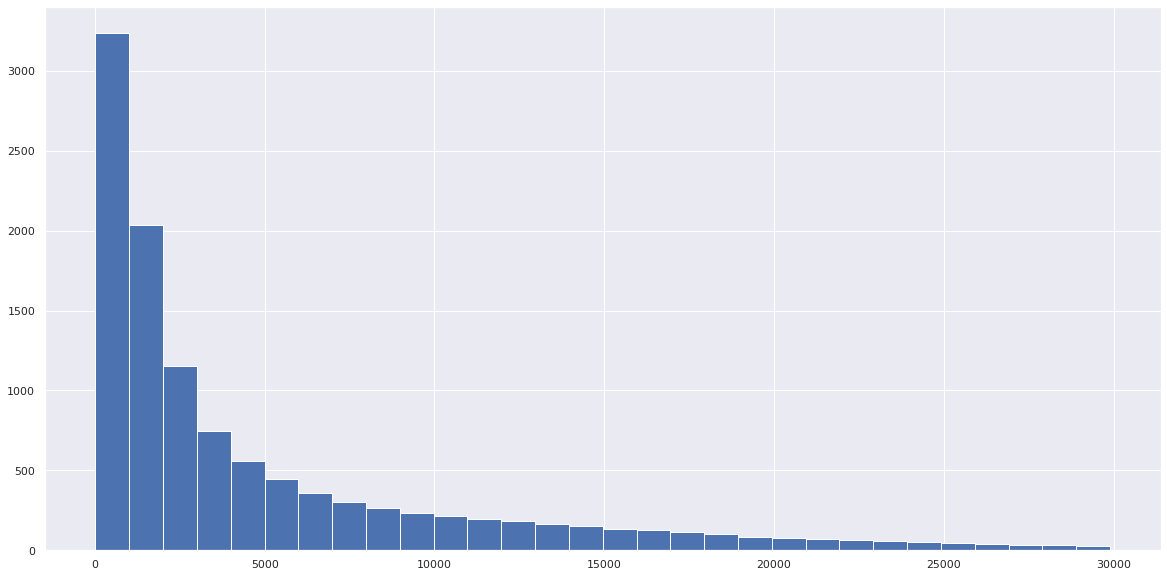

In [5]:
fig, axes = plt.subplots(figsize = (20, 10))
df_raw[df_raw['income'] < 30000].income.hist(bins=30)

In [6]:
df_raw.drop_duplicates(subset=['income']).sort_values(by='income', ascending = False).head(5)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
10998,USA,2008,100,100,176928.550,3.040600,43261.0
4899,ISL,2008,100,100,160645.270,0.003100,36527.0
3499,GBR,2008,100,100,141565.230,0.610300,34048.0
1599,CAN,2008,100,100,133454.840,0.333114,35895.0
3399,FRA,2008,100,100,122775.164,0.641882,30357.0


In [7]:
df_raw.drop_duplicates(subset=['income']).sort_values(by='income').head(5)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
1700,CHN,2007,1,100,16.719418,13.256400,5712.00000
5700,KOR,2008,1,100,17.317732,0.486070,19162.00000
1100,BOL,2008,1,100,20.584948,0.096841,3950.00000
11499,COD,2008,1,100,29.364283,0.624749,303.19305
6699,MDG,2010,1,100,29.411367,0.195463,950.00000


### Vérification de la population

L'unité de la variable pop est en centaine de millions d'habitants

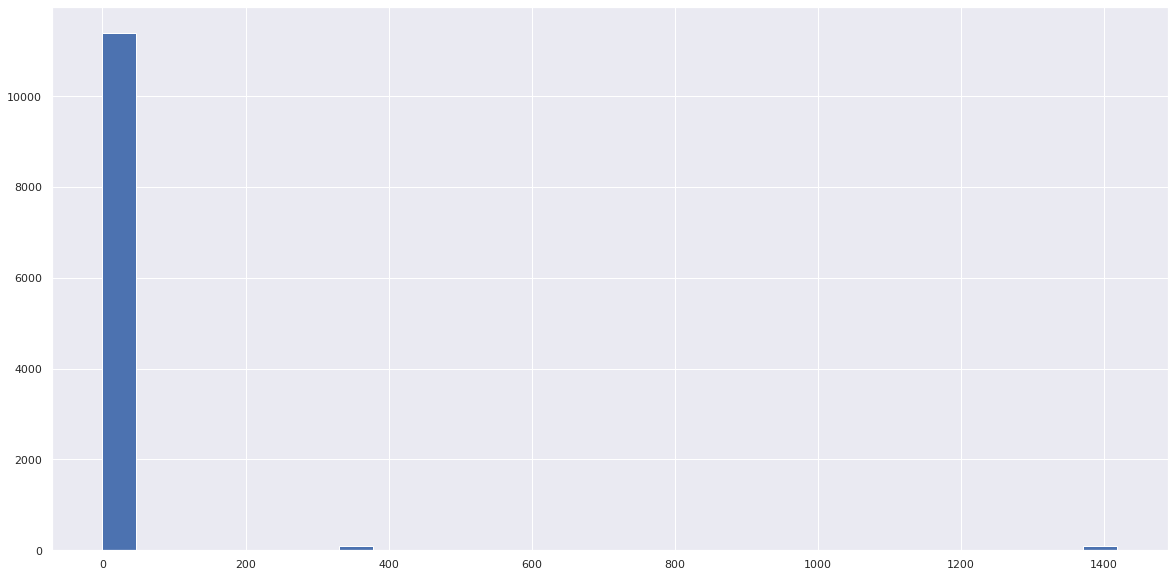

In [8]:
fig, axes = plt.subplots(figsize = (20, 10))
df_raw['pop'].hist(bins=30)

In [9]:
df_raw.drop_duplicates(subset=['country'])[df_raw.drop_duplicates(subset=['country'])['pop'] > 1].sort_values(by='pop', ascending = False)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
9099,RUS,2008,1,100,989.418600,1418.000000,14766.0
9199,SDN,2009,1,100,148.521180,346.000000,2345.0
6000,LBR,2007,1,100,37.782673,35.000000,372.0
1700,CHN,2007,1,100,16.719418,13.256400,5712.0
2200,CYP,2008,1,100,4406.335400,12.000000,26273.0
4400,IND,2007,1,100,247.838730,11.399640,2796.0
7099,MNE,2008,1,100,1344.219500,6.000000,10556.0
10899,USA,2008,1,100,663.476100,3.040600,43261.0
4300,IDN,2009,1,100,306.276430,2.273450,3689.0
1200,BRA,2008,1,100,144.028460,1.919715,9559.0


Nous avons 3 pays ayant des populations anormalement élevés,  la population du Libéria est, en 2007, de 3.5 Millions, la Russie en 2008 est de 141 Millions et le Soudan, en 2009, de 34 millions

### Vérification du GDP PPP

In [10]:
df_raw.drop_duplicates(subset=['gdpppp']).sort_values(by='gdpppp', ascending = False).head(10)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
3200,FJI,2008,1,100,308.17334,0.008430,4300332.0
6299,LUX,2008,1,100,5780.83740,0.004800,73127.0
8099,NOR,2008,1,100,3520.26150,0.047100,49070.0
10899,USA,2008,1,100,663.47610,3.040600,43261.0
4500,IRL,2008,1,100,2819.13500,0.043700,39268.0
7999,NLD,2008,1,100,2558.82080,0.163800,38065.0
4800,ISL,2008,1,100,5191.96830,0.003100,36527.0
300,AUT,2008,1,100,2958.07640,0.083200,36193.0
1500,CAN,2008,1,100,122.42481,0.333114,35895.0
9699,SWE,2008,1,100,2284.43290,0.106100,34371.0


Nous remarquons que le GDP PPP des îles Fidji est anormalement haut

### Vérification des valeurs manquantes

In [11]:
df_raw[df_raw['gdpppp'].isnull()].country.value_counts()

XKX    100
PSE    100
Name: country, dtype: int64

In [12]:
df_raw['country'].value_counts()[df_raw['country'].value_counts() != 100]

LTU    99
Name: country, dtype: int64

Nous voyons que les pays 'PSE' et 'XKX' n'ont pas de gdp ppp, ainsi que le pays 'LTU' n'a pas l'ensemple de ses percentiles.

### Nettoyage ayant des valeurs manquantes ou eronnées

In [13]:
df = df_raw.copy()

#### Correction de la population

In [14]:
for p in ['LBR', 'RUS', 'SDN', 'CYP', 'MNE']:
    df.loc[df['country'] == p, 'pop'] = df.loc[df['country'] == p, 'pop'] / 1000

#### Correction du GDP PPP

Nous allons remplacer la valeur de lu GDP PPP des îles Fidji, le territoire palestinien et Kosovo par sa valeur predicte. Nous allons chercher des variables ayant des coefficients de correlations proche de 1

In [15]:
df_temp = df[~(df['country'].isin(['XKX', 'FJI', 'PSE']))]

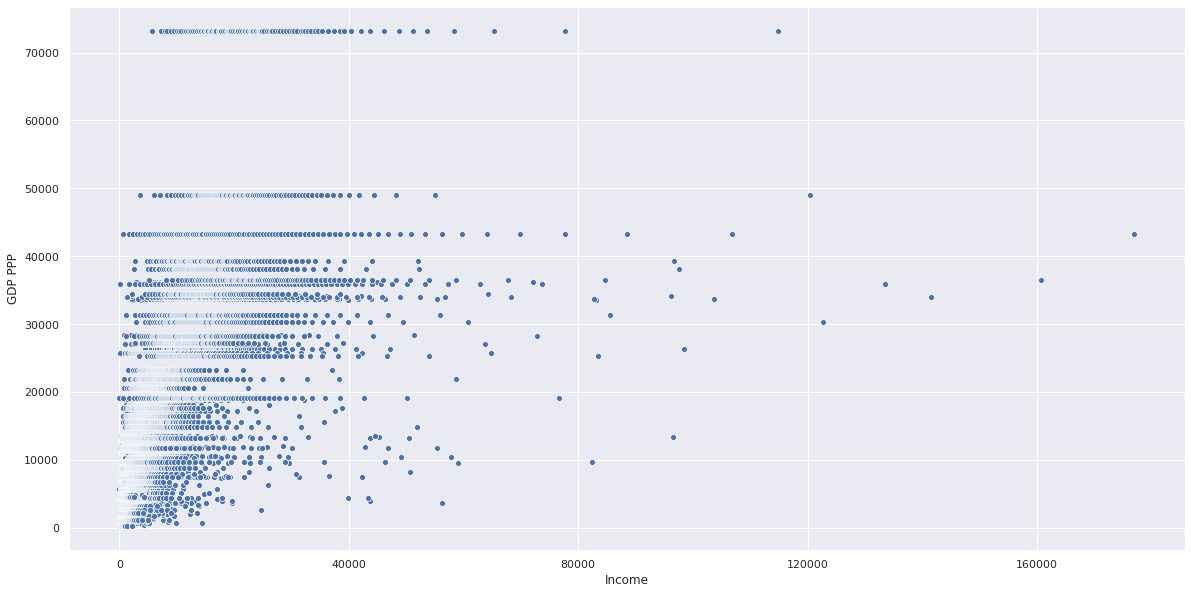

In [16]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="income", y="gdpppp", data=df_temp)
ax.set(xlabel='Income', ylabel='GDP PPP')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [17]:
df_temp['gdpppp'].corr(df_temp['income'], method='pearson')

0.6673228730093435

In [18]:
df_temp.loc[:, 'log_income'] = np.log(df_temp.loc[:, 'income'])
df_temp.loc[:, 'log_gdpppp'] = np.log(df_temp.loc[:, 'gdpppp'])

/home/heidoji/DataScience/Anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/heidoji/DataScience/Anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


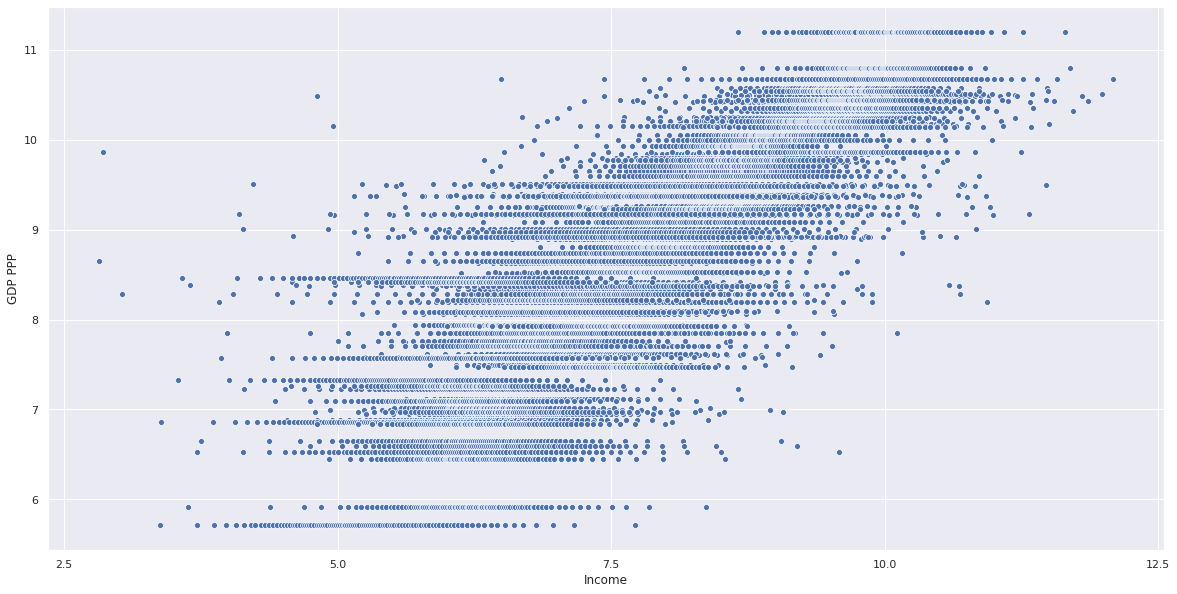

In [19]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="log_income", y="log_gdpppp", data=df_temp)
ax.set(xlabel='Income', ylabel='GDP PPP')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [20]:
np.log(df_temp['gdpppp']).corr(np.log(df_temp['income']), method='pearson')

0.8052829257332335

Nous voyons qu'avec une transformation avec un logarithme, nous obtenons une indice de correlation plus intéressant. Nous allons appliquer une régression linéaire pour prédire les valeurs manquantes

In [21]:
X = df_temp['log_gdpppp'].values
y = df_temp['log_income'].values

In [22]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.649 +/- 0.002
Test accuracy : 0.648 +/- 0.010


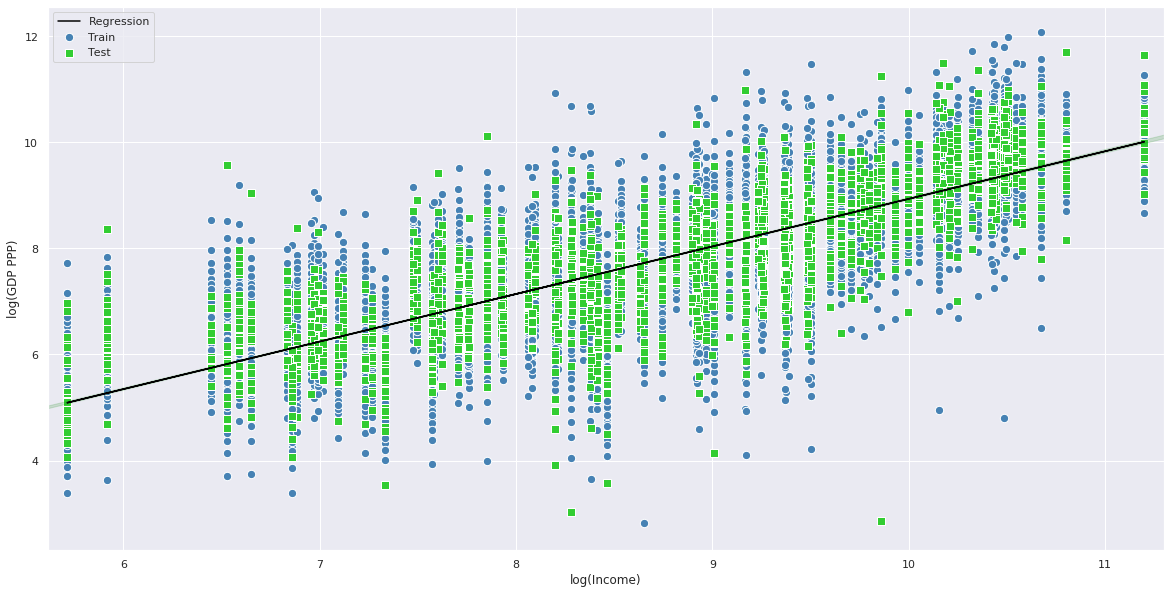

In [23]:
y_train_pred = slr.predict(X_train.reshape(-1, 1))

x_line = np.linspace(5.5, 11.5, 100)
y_pred = slr.predict(x_line.reshape(-1, 1))
Sy = np.sqrt(1/X_train.shape[0] + ((x_line - y_train.mean())**2)  / ((X_train - y_train.mean())**2).sum()) * np.sqrt(mean_squared_error(y_train, y_train_pred))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.fill_between(x_line,
                y_pred + 1.65 * Sy,
                y_pred - 1.65 * Sy,
                alpha=0.15, color='green')
plt.legend(loc = 'upper left')
axes.set_xlim([X_train.min()-0.1, X_train.max()+0.1])
plt.xlabel('log(Income)')
plt.ylabel('log(GDP PPP)')
plt.show()


In [24]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.647
Test accuracy : 0.654 


Nous allons essayer avec la moyenne et l'écart type des revenus de trouver une régression plus performante

In [25]:
data = list(zip(np.log(df_temp.groupby('country').mean().income), np.log(df_temp.groupby('country').std().income), np.log(df_temp.groupby('country').mean().gdpppp)))
df_mean = pd.DataFrame(data, columns=['Mean', 'Std', 'Gdpppp'])

In [26]:
np.log(df_mean['Mean']).corr(np.log(df_mean['Std']), method='pearson')

0.9599028965666162

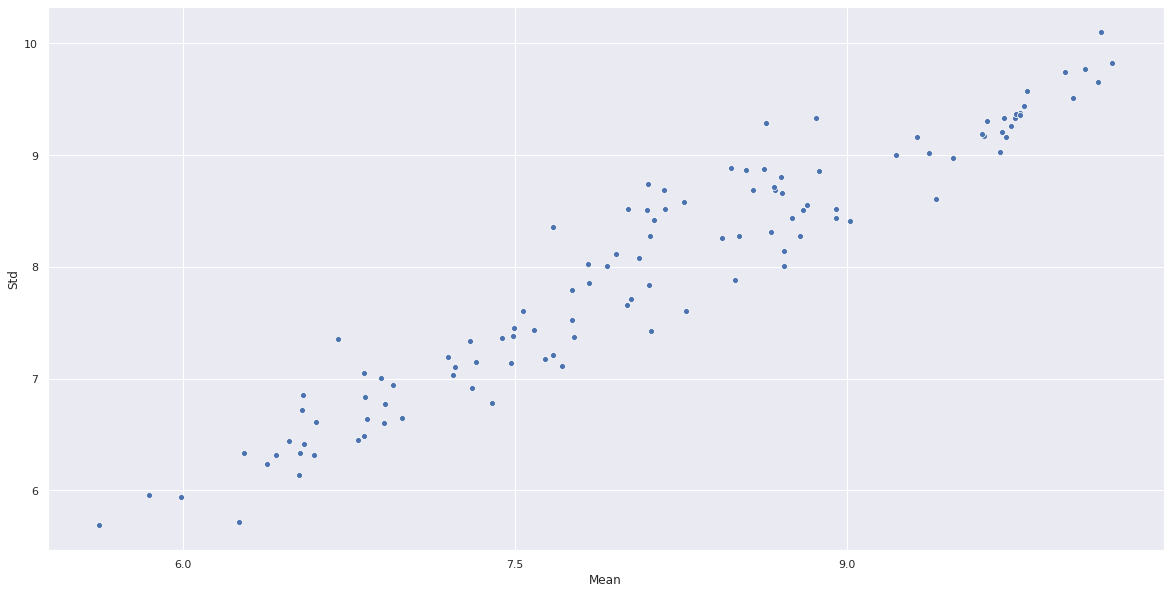

In [27]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="Mean", y="Std", data=df_mean)
ax.set(xlabel='Mean', ylabel='Std')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

Nous observons que la déviation standard et la moyenne du revenu sont fortement corrélées. Ainsi, nous allons proceder à une régression linéaire simple avec les deux variables indépendantes et choisir celle qui est la plus performante

Regression Linéaire avec la moyenne

In [28]:
X = df_mean.iloc[:, 0].values
y = df_mean.iloc[:, -1].values

In [29]:
slr_mean = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr_mean.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr_mean.score(X_train.reshape(-1, 1), y_train)
    score_test = slr_mean.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.889 +/- 0.009
Test accuracy : 0.882 +/- 0.042


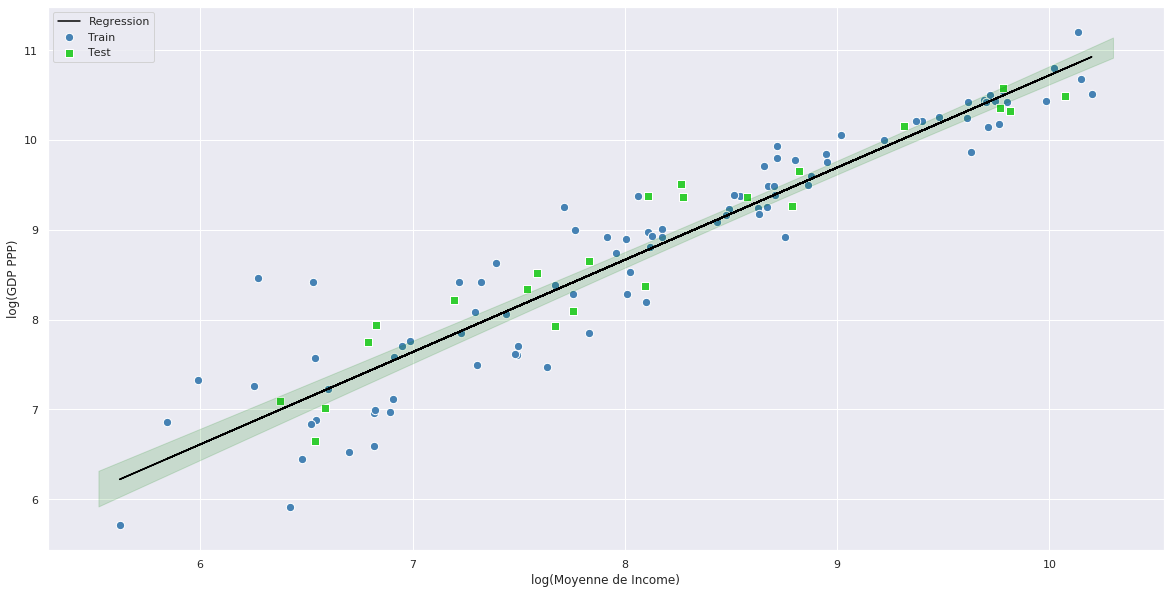

In [30]:
y_train_pred = slr_mean.predict(X_train.reshape(-1, 1))
y_test_pred = slr_mean.predict(X_test.reshape(-1, 1))

x_line = np.linspace(X_train.min()-0.1, X_train.max()+0.1, 100)
y_pred = slr_mean.predict(x_line.reshape(-1, 1))
Sy = np.sqrt(1/X_train.shape[0] + ((x_line - y_train.mean())**2)  / ((X_train - y_train.mean())**2).sum()) * np.sqrt(mean_squared_error(y_train, y_train_pred))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.fill_between(x_line,
                y_pred + 1.65 * Sy,
                y_pred - 1.65 * Sy,
                alpha=0.15, color='green')
plt.legend(loc = 'upper left')
plt.xlabel('log(Moyenne de Income)')
plt.ylabel('log(GDP PPP)')
plt.show()

In [31]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.885
Test accuracy : 0.918 


In [32]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 0.188
MSE Test : 0.106


Regression Linéaire avec la déviation standard

In [33]:
X = df_mean.iloc[:, 1].values

In [34]:
slr_std = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr_std.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr_std.score(X_train.reshape(-1, 1), y_train)
    score_test = slr_std.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.788 +/- 0.021
Test accuracy : 0.760 +/- 0.100


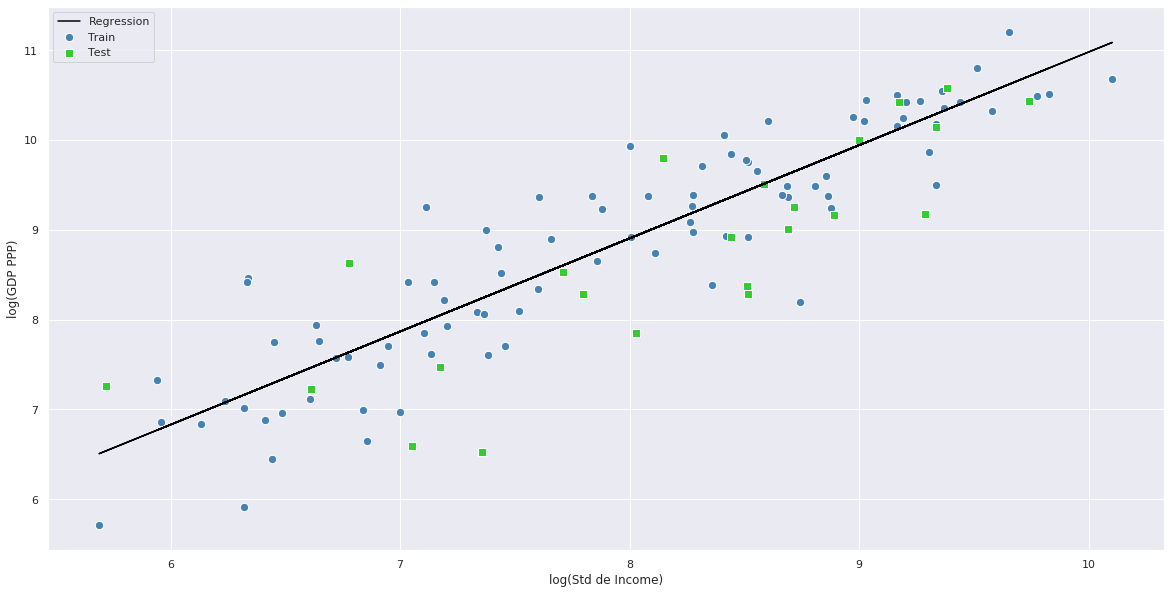

In [35]:
y_train_pred = slr_std.predict(X_train.reshape(-1, 1))
y_test_pred = slr_std.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('log(Std de Income)')
plt.ylabel('log(GDP PPP)')
plt.show()

In [36]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.827
Test accuracy : 0.578 


In [37]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 0.277
MSE Test : 0.587


Nous constatons que la régression linéaire avec la moyenne est la plus performante avec un R² de 0.878 et R² de prédiction de 0.937 et une MSE de 0.195.

Nous utiliserons ce modèle pour prédire les valeurs de GDP PPP manquantes.

In [38]:
for pays in ['XKX', 'FJI', 'PSE']:
    filt = df['country'] == pays
    df.loc[filt, 'gdpppp'] = np.exp(slr_mean.predict(np.log(df[filt].mean().income).reshape(-1, 1)))[0]

## Donnée Gini

### Ajout du coefficient de Gini

Dans la liste des coefficients de Gini par pays, de nombreuses valeurs sont manquantes. Concernant la variation du coefficient de Gini en fonction des années, il serait pertinent de vérifier si ces variations sont significatives

Pour se faire, nous allons regarder si les variations sont comprises entre plus ou moins deux ecart-types.

In [39]:
df_gini = pd.DataFrame(columns = ['country name', 'country', 'Year', 'Gini'])

Nous allons réorganiser ce dataframe pour l'exploiter plus facilement

In [40]:
for i in range(0, df_gini_raw.shape[0]):
    for j in range(4, df_gini_raw.shape[1]):
        if df_gini_raw.iloc[i, j] > 0:
            df_gini.loc[i*j]=[df_gini_raw.iloc[i,0], df_gini_raw.iloc[i,1], 1956+j, df_gini_raw.iloc[i, j]]

In [41]:
df_gini.reset_index().drop(columns=['index'], inplace = True)

Nous constatons que des pays n'ont aucun coefficient de Gini de calculer, ainsi, sans ces données, il n'est pas possible d'exploiter les informations de ce pays

In [42]:
df_gini_unique = pd.merge(df_gini, df_gini.groupby('country').mean(), how = 'right', on = 'country')
df_gini_unique.rename(columns={'Gini_x': 'Gini', 'Gini_y': 'Mean Gini'}, inplace=True)

In [43]:
df_gini_unique['Centered Gini'] = (df_gini_unique['Gini'] - df_gini_unique['Gini']) / df_gini_unique['Gini'].std()

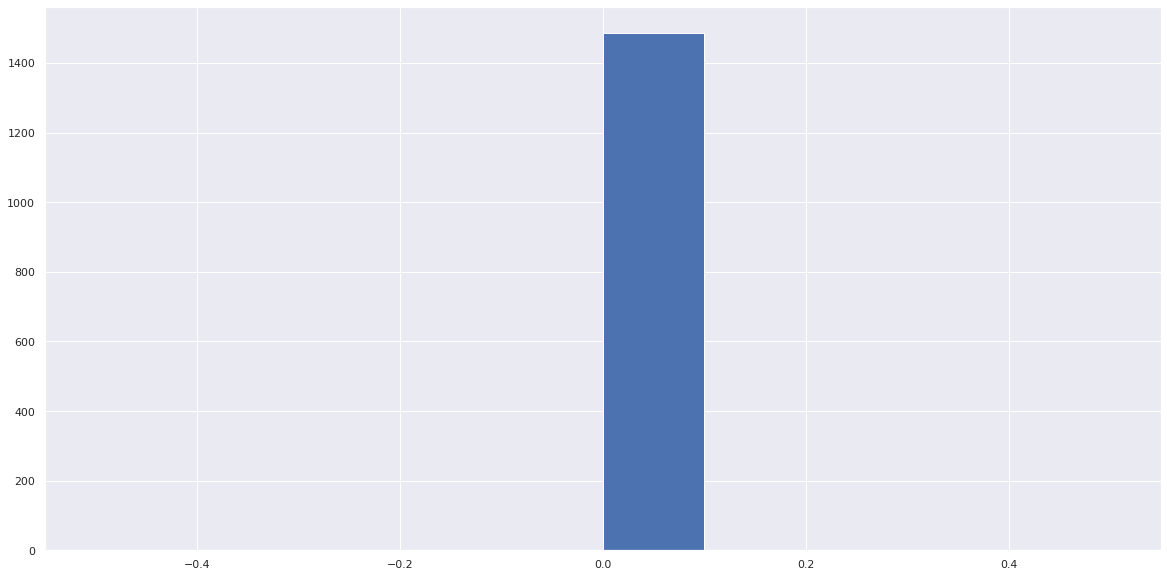

In [44]:
fig, axes = plt.subplots(figsize = (20, 10))
df_gini_unique['Centered Gini'].hist()

Nous voyons que l'écart-type pour la variation du coefficient de Gini n'est pas significative, par conséquent nous pouvons utiliser la moyenne au lieu d'une année spécifique.

In [45]:
df_gini_unique.drop_duplicates(subset=['country'], inplace = True)
df_gini_unique.drop(columns=['Year', 'Gini'], inplace = True)
df = pd.merge(df, df_gini_unique[['country name', 'Mean Gini', 'country']], how = 'right', on = 'country')

In [46]:
df = df[~(df['year_survey'].isna())]

## Données Elasticity

In [47]:
df_elasticity = df_elasticity[['wbcode','iso3', 'year', 'IGEincome']]
df_elasticity = df_elasticity[~(df_elasticity['IGEincome'].isna())]

In [48]:
df_elasticity.drop_duplicates(subset=['iso3'], inplace = True)
df_elasticity.rename(columns={'iso3': 'country', 'IGEincome' : 'CoefElasticity'}, inplace=True)

In [49]:
df = pd.merge(df, df_elasticity[['country', 'CoefElasticity']], how = 'left', on = 'country')

In [50]:
df[df['CoefElasticity'].isna()]['country name'].unique()

array(['Argentina', 'Armenia', 'Azerbaijan', 'Burkina Faso', 'Bulgaria',
       'Bhutan', 'Central African Republic', "Cote d'Ivoire", 'Cameroon',
       'Costa Rica', 'Dominican Republic', 'Estonia', 'Fiji', 'Georgia',
       'Honduras', 'Hungary', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq',
       'Iceland', 'Israel', 'Kosovo', 'Lao PDR', 'Liberia', 'Sri Lanka',
       'Lithuania', 'Moldova', 'Mexico', 'Montenegro', 'Mozambique',
       'Mauritania', 'Niger', 'Nicaragua', 'Philippines', 'Poland',
       'Paraguay', 'Sudan', 'El Salvador', 'Serbia', 'Eswatini',
       'Syrian Arab Republic', 'Thailand', 'Tajikistan', 'Turkey',
       'Ukraine', 'Uruguay', 'Venezuela, RB', 'West Bank and Gaza',
       'Yemen, Rep.'], dtype=object)

Nous avons 46 pays n'ayant pas une coefficient d'elasticité. Nous allons les renseigner en fonction des zones géographiques

In [51]:
N_Europe = ['Iceland']
Europe = ['Armenia', 'Azerbaijan', 'Bulgaria', 'Estonia', 'Georgia', 'Hungary', 'Moldova', 'Montenegro', 'Poland', 
          'Serbia', 'Ukraine']
Asia = ['Bhutan', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Israel', 'Lao PDR', 'Sri Lanka', 'Philippines', 
       'Syrian Arab Republic', 'Thailand', 'Tajikistan', 'Turkey', 'Yemen, Rep.']
Africa = ['Argentina', 'Burkina Faso', 'Central African Republic', "Cote d'Ivoire", 'Cameroon',
          'Costa Rica', 'Dominican Republic', 'Fiji', 'Honduras', 'Liberia', 'Mexico', 'Mozambique', 
          'Mauritania', 'Niger', 'Nicaragua', 'Paraguay', 'Sudan', 'El Salvador', 'Eswatini', 'Uruguay', 'Venezuela, RB']

In [52]:
liste_pays = [N_Europe, Europe, Asia, Africa]
liste_elas = [0.2, 0.4, 0.5, 0.66]

liste = list(zip(liste_pays, liste_elas))

In [53]:
for liste_pays, elas in liste:
    for pays in liste_pays:
        df.loc[df['country name'] == pays, 'CoefElasticity'] = elas

## Mission 1 

Résumez les données utilisées :

* année(s) des données utilisées sont 2004, 2006, 2007, 2008, 2009, 2010, 2011 
* nombre de pays présents après vérification des données est de 111 pays;
* population couverte par l'analyse (en termes de pourcentage de la population mondiale).

Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective :

* De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
* Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?


In [54]:
df['year_survey'].unique()

array([2008., 2009., 2010., 2007., 2006., 2011., 2004.])

In [55]:
f"Il y a {df['country'].unique().shape[0]} pays dans le dataframe après nettoyage des données"

'Il y a 114 pays dans le dataframe après nettoyage des données'

In [56]:
f"L'étude couvre {(df.drop_duplicates(subset=['country']).sum()['pop'] / 67 * 100):0.2f} % de la population mondiale"

"L'étude couvre 90.95 % de la population mondiale"

**De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?**

Il s'agit de percentiles, c'est-à-dire de quantité représentant 1%

**Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?**

Cela permet d'avoir une granularité plus fine et une analyse plus précise pour discréminer des groupes ou des tendances.

## Mission 2


Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
* Représentez la courbe de Lorenz de chacun des pays choisis.
* Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
* Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?


Nous allons choisir des pays selon leur congiguration socio-économique, c'est-à-dire des pays pauvres, en voie de développement et des pays riches, des pays exportateurs nets et des pays dont l'économie se base sur l'exploitation d'une seule ressource.

Pour ce faire, nous allons choisir la Chine, un pays du golfe, un pays appartenant au BRICS, un pays riche peu peuplé et 4 pays appartenant à chaque quartile du GDP PPP.

In [57]:
df[df['gdpppp'] < df.quantile(.25)['gdpppp']].sample(n=1, random_state=1)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
7686,NER,2007.0,88.0,100.0,995.6593,0.14704,631.0,Niger,39.825,0.66


In [58]:
df[df['gdpppp'].isin(df.quantile([.25, .5])['gdpppp'].values)].sample(n=1, random_state=2)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
7811,NIC,2009.0,13.0,100.0,568.1765,0.056778,2576.0,Nicaragua,50.6,0.66


In [59]:
df[df['gdpppp'].isin(df.quantile([.5, .75])['gdpppp'].values)].sample(n=1, random_state=2)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
6112,LTU,2008.0,13.0,100.0,2732.966,0.0336,17571.0,Lithuania,35.723077,NaN


In [60]:
df[df['gdpppp'] > df.quantile(.75)['gdpppp']].sample(n=1, random_state=1)

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
4987,ISR,2008.0,88.0,100.0,19819.168,0.073081,25740.0,Israel,39.163636,0.5


In [61]:
df[df['country name'] == 'China']

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
1700,CHN,2007.0,1.0,100.0,16.719418,13.2564,5712.0,China,39.21,0.399
1701,CHN,2007.0,2.0,100.0,234.150730,13.2564,5712.0,China,39.21,0.399
1702,CHN,2007.0,3.0,100.0,282.894900,13.2564,5712.0,China,39.21,0.399
1703,CHN,2007.0,4.0,100.0,323.826500,13.2564,5712.0,China,39.21,0.399
1704,CHN,2007.0,5.0,100.0,362.260600,13.2564,5712.0,China,39.21,0.399
...,...,...,...,...,...,...,...,...,...,...
1795,CHN,2007.0,96.0,100.0,7588.195000,13.2564,5712.0,China,39.21,0.399
1796,CHN,2007.0,97.0,100.0,8317.553000,13.2564,5712.0,China,39.21,0.399
1797,CHN,2007.0,98.0,100.0,9382.284000,13.2564,5712.0,China,39.21,0.399
1798,CHN,2007.0,99.0,100.0,11071.510000,13.2564,5712.0,China,39.21,0.399


In [62]:
df[df['country name'] == 'Brazil']

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
1200,BRA,2008.0,1.0,100.0,144.02846,1.919715,9559.0,Brazil,56.933333,0.635
1201,BRA,2008.0,2.0,100.0,245.92259,1.919715,9559.0,Brazil,56.933333,0.635
1202,BRA,2008.0,3.0,100.0,347.86597,1.919715,9559.0,Brazil,56.933333,0.635
1203,BRA,2008.0,4.0,100.0,430.76090,1.919715,9559.0,Brazil,56.933333,0.635
1204,BRA,2008.0,5.0,100.0,506.10590,1.919715,9559.0,Brazil,56.933333,0.635
...,...,...,...,...,...,...,...,...,...,...
1295,BRA,2008.0,96.0,100.0,16323.82100,1.919715,9559.0,Brazil,56.933333,0.635
1296,BRA,2008.0,97.0,100.0,18917.69100,1.919715,9559.0,Brazil,56.933333,0.635
1297,BRA,2008.0,98.0,100.0,22820.66800,1.919715,9559.0,Brazil,56.933333,0.635
1298,BRA,2008.0,99.0,100.0,29642.62000,1.919715,9559.0,Brazil,56.933333,0.635


In [63]:
df[df['country name'].str.contains('Iran')]

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
4600,IRN,2008.0,1.0,100.0,441.56308,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4601,IRN,2008.0,2.0,100.0,701.21075,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4602,IRN,2008.0,3.0,100.0,854.72504,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4603,IRN,2008.0,4.0,100.0,969.65260,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4604,IRN,2008.0,5.0,100.0,1067.15340,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
...,...,...,...,...,...,...,...,...,...,...
4695,IRN,2008.0,96.0,100.0,15637.79700,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4696,IRN,2008.0,97.0,100.0,17546.96000,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4697,IRN,2008.0,98.0,100.0,20007.95900,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5
4698,IRN,2008.0,99.0,100.0,24767.04000,0.719563,10446.0,"Iran, Islamic Rep.",43.133333,0.5


In [64]:
df[df['country name'] == 'Luxembourg']

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
6199,LUX,2008.0,1.0,100.0,5780.8374,0.0048,73127.0,Luxembourg,30.99,0.380792
6200,LUX,2008.0,2.0,100.0,7315.2686,0.0048,73127.0,Luxembourg,30.99,0.380792
6201,LUX,2008.0,3.0,100.0,7891.2456,0.0048,73127.0,Luxembourg,30.99,0.380792
6202,LUX,2008.0,4.0,100.0,8312.0310,0.0048,73127.0,Luxembourg,30.99,0.380792
6203,LUX,2008.0,5.0,100.0,8945.6380,0.0048,73127.0,Luxembourg,30.99,0.380792
...,...,...,...,...,...,...,...,...,...,...
6294,LUX,2008.0,96.0,100.0,53724.6300,0.0048,73127.0,Luxembourg,30.99,0.380792
6295,LUX,2008.0,97.0,100.0,58382.3120,0.0048,73127.0,Luxembourg,30.99,0.380792
6296,LUX,2008.0,98.0,100.0,65280.2200,0.0048,73127.0,Luxembourg,30.99,0.380792
6297,LUX,2008.0,99.0,100.0,77673.3700,0.0048,73127.0,Luxembourg,30.99,0.380792


Nous avons 8 pays, la Chine, le Brasil, l'Iran, le Malawi, le Nicaragua, l'Estonie, Israël et le Luxembourg

In [65]:
pays = ['Malawi', 'Nicaragua', 'Estonia', 'Israel', 'China', 'Brazil', 'Iran, Islamic Rep.', 'Luxembourg']

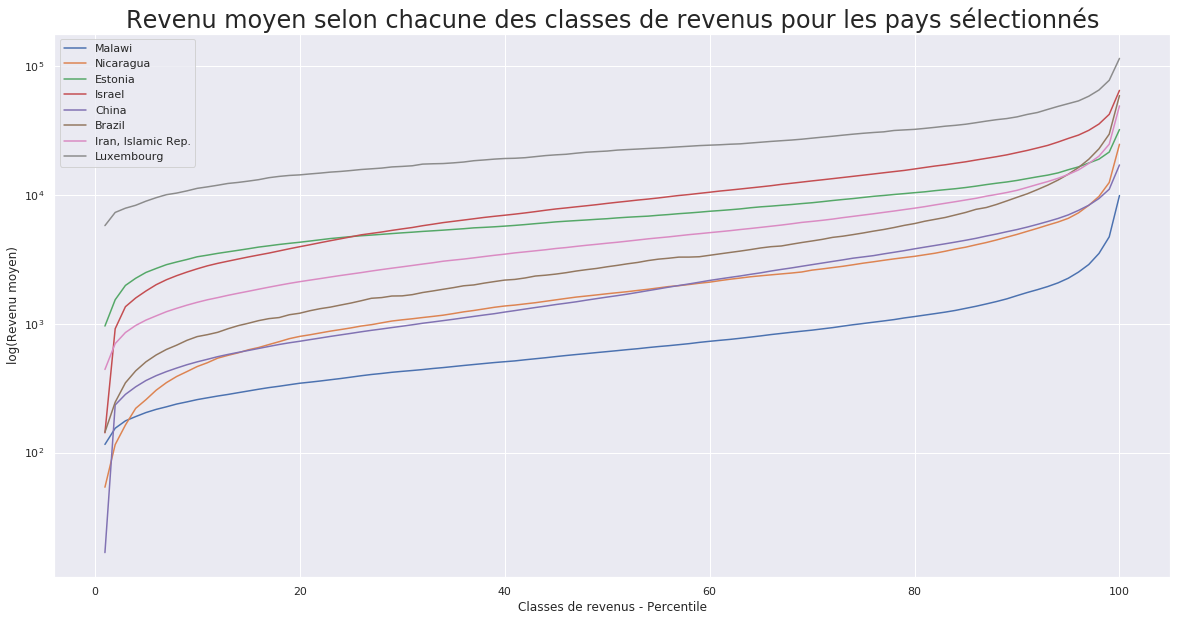

In [66]:
fig, axes = plt.subplots(1, 1, figsize = (20, 10))

for p in pays:
    plt.plot(df[df['country name'] == p]['quantile'], df[df['country name'] == p].income, label = p)

plt.xlabel('Classes de revenus - Percentile')
plt.ylabel('log(Revenu moyen)')
plt.yscale('log')
plt.title('Revenu moyen selon chacune des classes de revenus pour les pays sélectionnés', fontsize=_FONTSIZETITLE_)
plt.legend(loc='upper left')
plt.savefig('Images/courbe_revenue_log.png')
plt.show()

### Représentez la courbe de Lorenz de chacun des pays choisis.

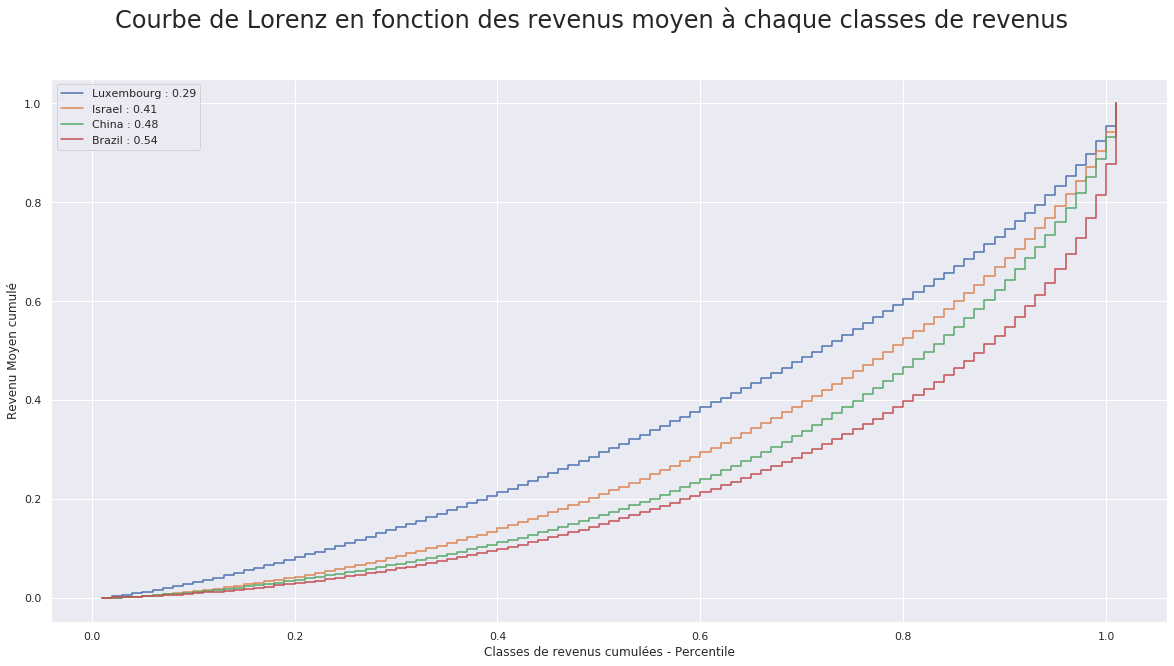

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle(f"Courbe de Lorenz en fonction des revenus moyen à chaque classes de revenus", fontsize= _FONTSIZETITLE_)

axes.set_xlabel('Classes de revenus cumulées - Percentile')
axes.set_ylabel('Revenu Moyen cumulé')
    
for p in ['Luxembourg', 'Israel', 'China', 'Brazil']:
    lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df[df['country name'] == p]['income']))

    xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

    plt.plot(xaxis,lorenz,drawstyle='steps-post', label = f"{p} : {gini:0.2f}")
    plt.legend(loc='upper left')

plt.savefig('Images/lorenz.png')
plt.show()

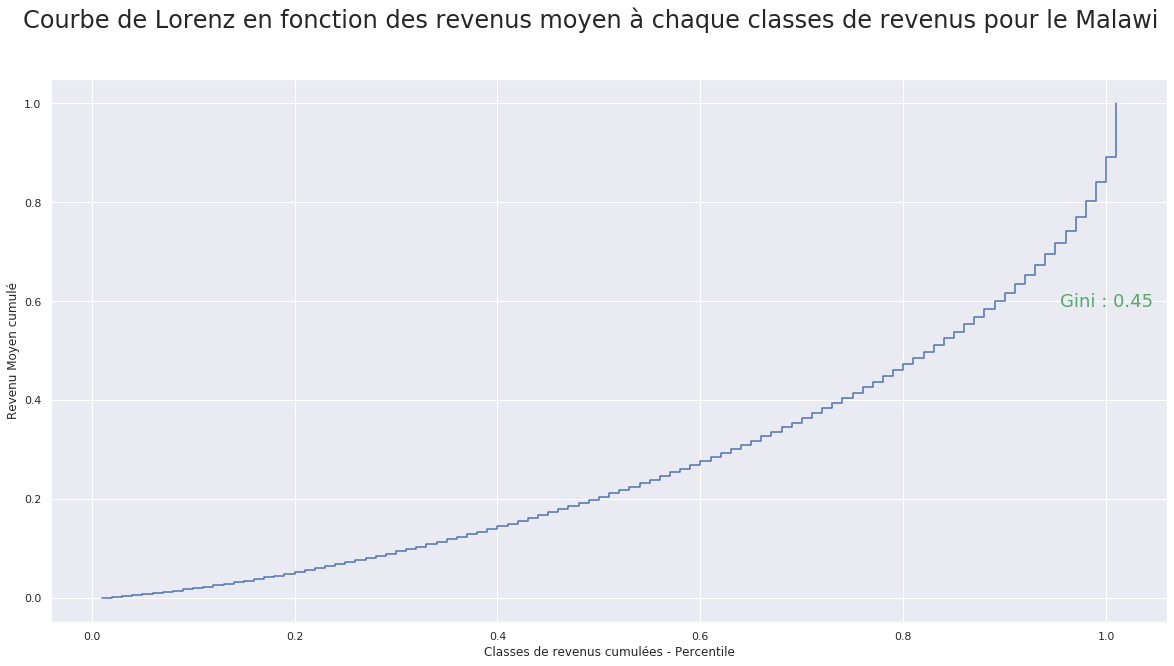

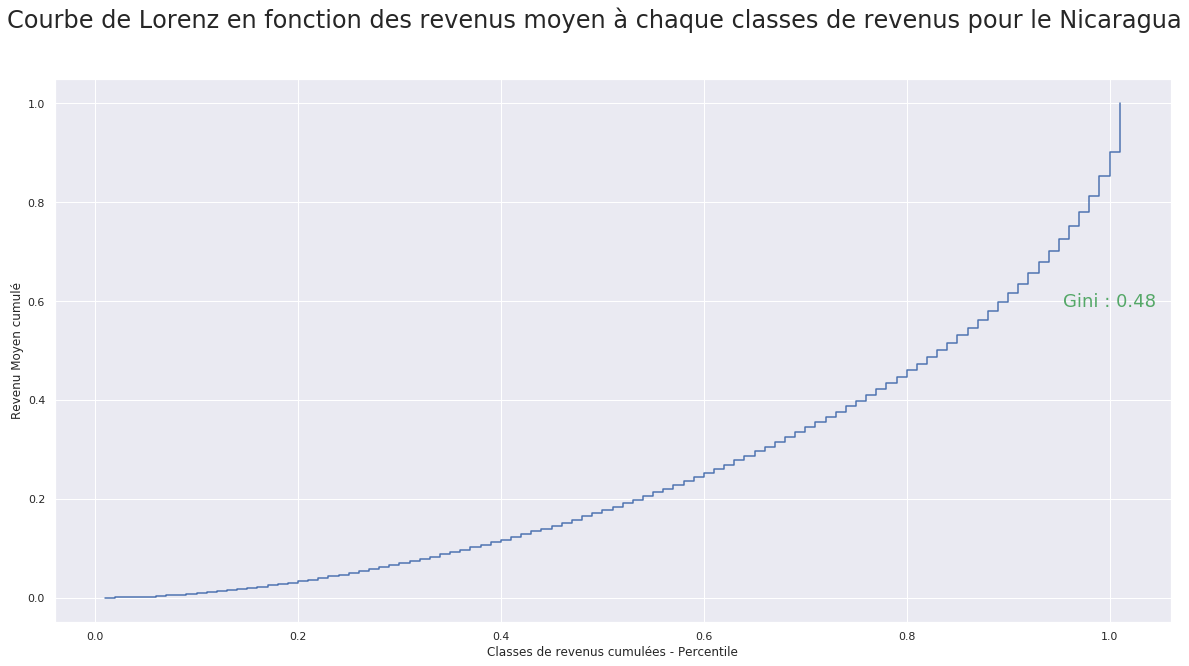

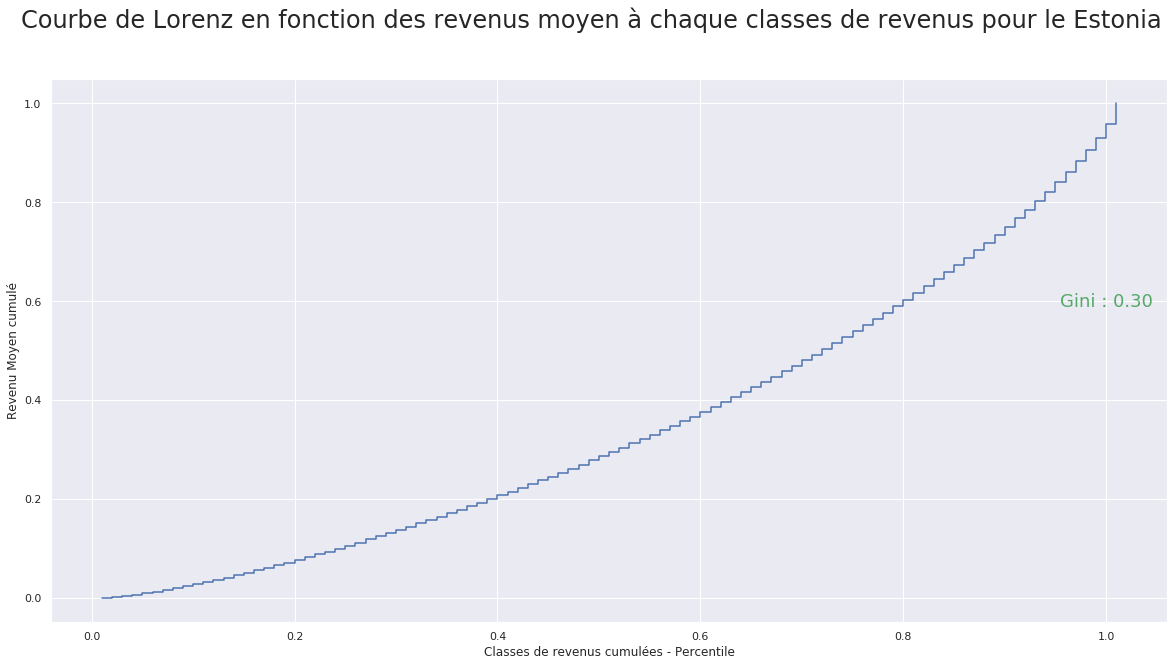

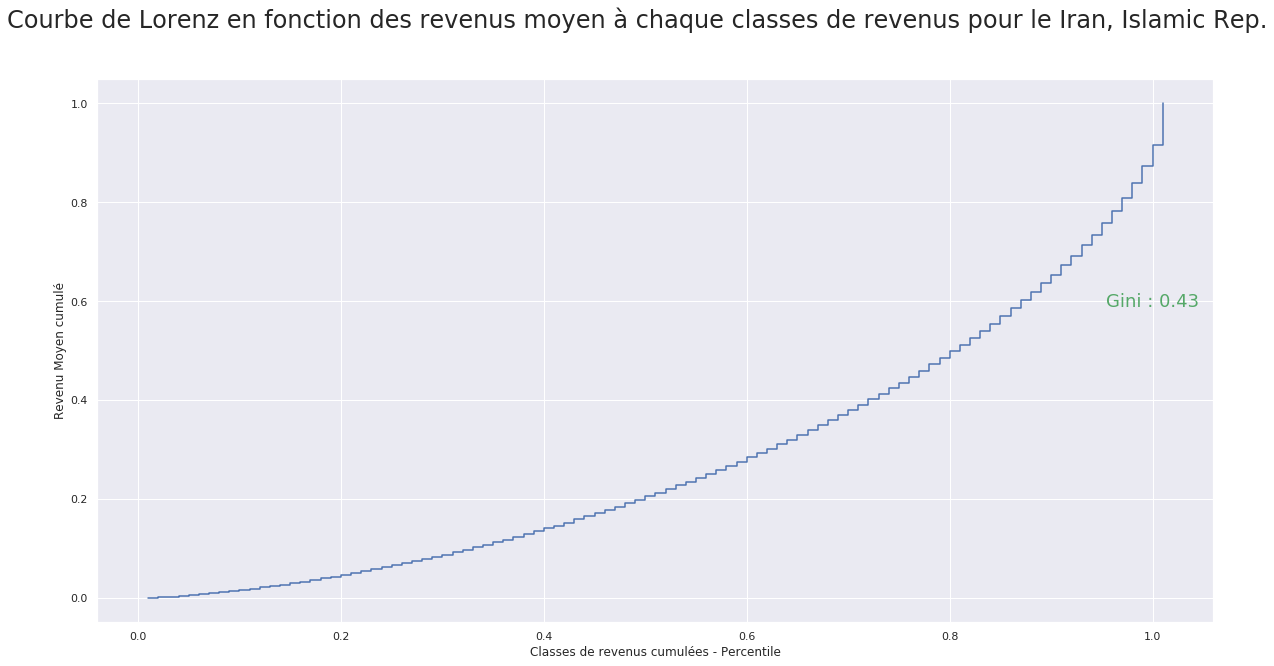

In [68]:
for p in ['Malawi', 'Nicaragua', 'Estonia', 'Iran, Islamic Rep.']:
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    fig.suptitle(f"Courbe de Lorenz en fonction des revenus moyen à chaque classes de revenus pour le {p}", fontsize= _FONTSIZETITLE_)
    
    axes.set_xlabel('Classes de revenus cumulées - Percentile')
    axes.set_ylabel('Revenu Moyen cumulé')
    
    lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df[df['country name'] == p]['income']))

    xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.text(1, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")

plt.show()

### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

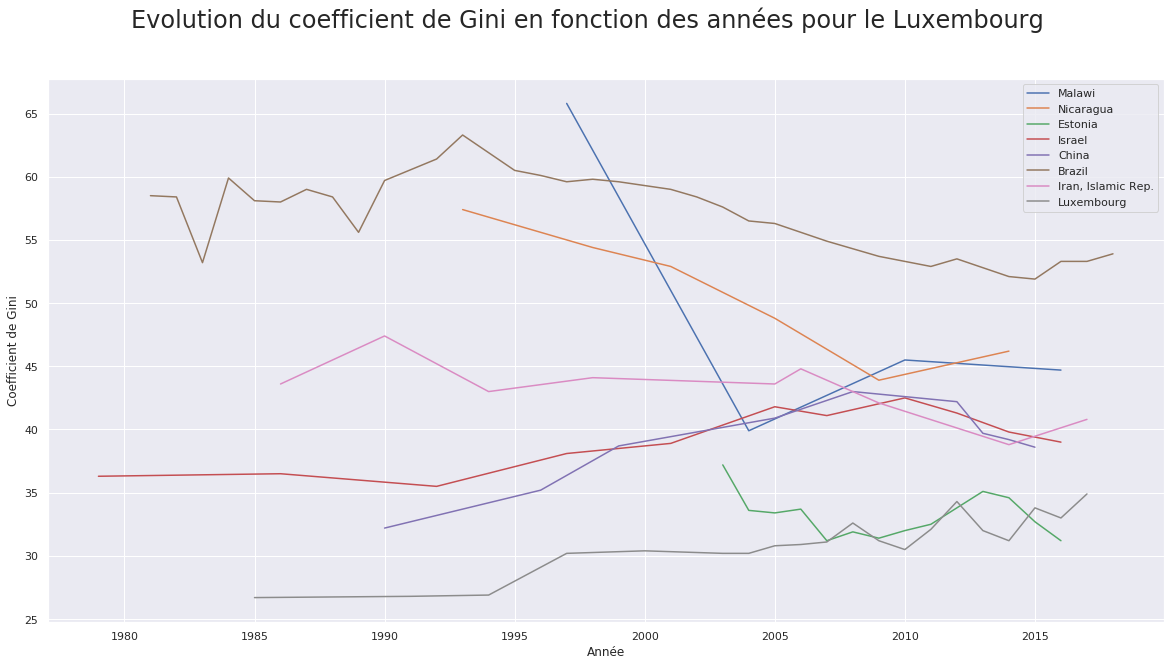

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

for p in pays:

    fig.suptitle(f"Evolution du coefficient de Gini en fonction des années pour le {p}", fontsize= _FONTSIZETITLE_)
    
    axes.set_xlabel('Année')
    axes.set_ylabel('Coefficient de Gini')
    
    plt.plot(df_gini.sort_values(by=['Year'])[df_gini.sort_values(by=['Year'])['country name'] == p]['Year']
             , df_gini[df_gini['country name'] == p]['Gini'], label = p)
    plt.legend(loc='upper right')

plt.savefig('Images/evo_gini.png')
plt.show()

### Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

#### Les 5 pays ayant l'indice de Gini le plus élevé

In [70]:
df_gini_unique.sort_values(by=['Mean Gini']).reset_index()

,index,country name,country,Mean Gini,Centered Gini
0,1256,Slovenia,SVN,24.990909,0.0
1,395,Czech Republic,CZE,25.907692,0.0
2,436,Denmark,DNK,26.133333,0.0
3,1352,Slovak Republic,SVK,26.607692,0.0
4,1147,Norway,NOR,26.688235,0.0
...,...,...,...,...,...
159,1351,Suriname,SUR,57.600000,0.0
160,251,Belize,BLZ,57.733333,0.0
161,247,Botswana,BWA,58.175000,0.0
162,1125,Namibia,NAM,61.133333,0.0


In [71]:
df_gini_unique.sort_values(by=['Mean Gini'], ascending = False).reset_index().head()

,index,country name,country,Mean Gini,Centered Gini
0,1140,South Africa,ZAF,61.714286,0.0
1,1125,Namibia,NAM,61.133333,0.0
2,247,Botswana,BWA,58.175000,0.0
3,251,Belize,BLZ,57.733333,0.0
4,1351,Suriname,SUR,57.600000,0.0


#### Les 5 pays ayant l'indice de Gini le plus faible

In [72]:
df_gini_unique.sort_values(by=['Mean Gini']).reset_index().head()

,index,country name,country,Mean Gini,Centered Gini
0,1256,Slovenia,SVN,24.990909,0.0
1,395,Czech Republic,CZE,25.907692,0.0
2,436,Denmark,DNK,26.133333,0.0
3,1352,Slovak Republic,SVK,26.607692,0.0
4,1147,Norway,NOR,26.688235,0.0


#### La position de la France

In [73]:
f"La France se trouve en {df_gini_unique.sort_values(by=['Mean Gini']).reset_index()[df_gini_unique.sort_values(by=['Mean Gini']).reset_index()['country name'] == 'France'].index[0] + 1}e position"

'La France se trouve en 36e position'

## Mission 3

* Générez un grand nombre  de réalisations d'une variable que nous appellerons ln(Yparent) selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. _n_ doit être supérieur à 1000 fois le nombre de quantiles.

In [74]:
nb_quantiles = 100 
n = 1000 * nb_quantiles
ln_y_parent = st.norm(0,1).rvs(size=n)

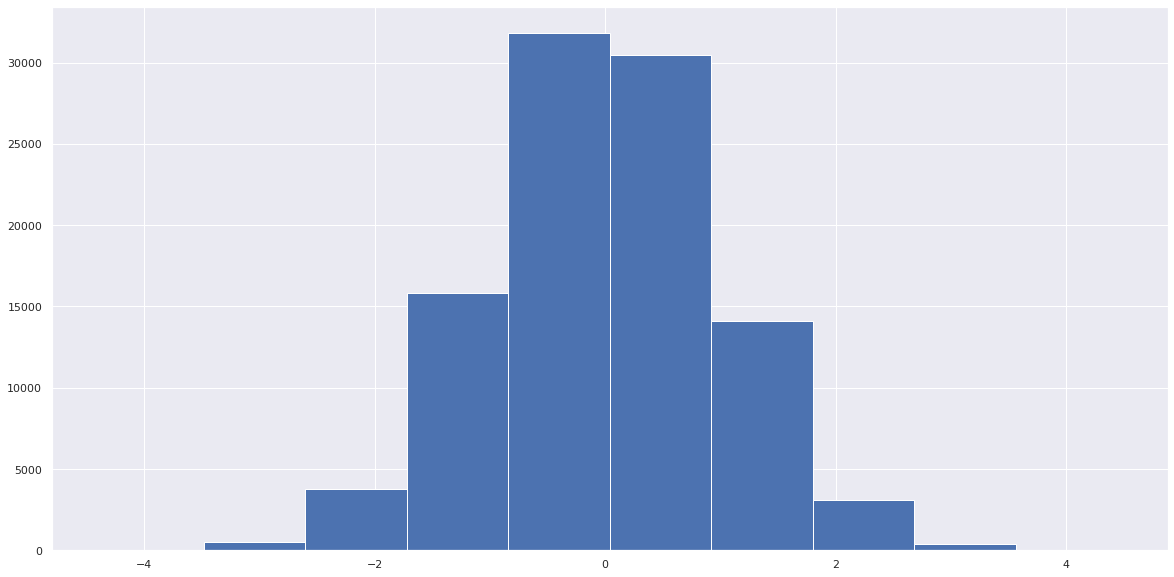

In [75]:
fig, axes = plt.subplots(figsize = (20, 10))
pd.Series(ln_y_parent).hist()

* Générez n réalisations du terme d'erreur  selon une loi normale de moyenne 0 et d'écart-type

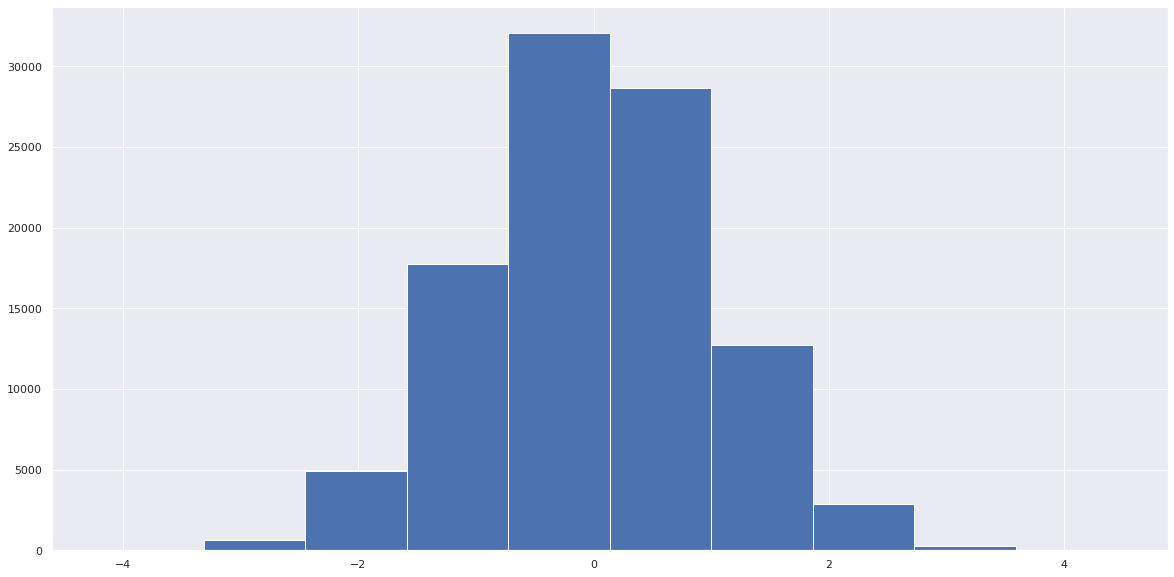

In [76]:
epsilon = st.norm(0,1).rvs(size=n)

fig, axes = plt.subplots(figsize = (20, 10))
pd.Series(epsilon).hist()

* Pour une valeur donnée de pj (par exemple 0.9), calculez ychild = e(α+ln()+ε). Le choix de α n'a aucune incidence sur le résultat final et peut être supprimé. A ce stade, ychild contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [77]:
pj = 0.9

y_child = np.exp(pj*ln_y_parent + epsilon)
y_parent = np.exp(ln_y_parent)

* Pour chacun des n individus générés, calculez la classe de revenu ci_child ainsi que la classe de revenu de ses parents ci_parent, à partir de y_child et y_parent.

In [78]:
sample = OCR.compute_quantiles(y_child, y_parent, nb_quantiles)

* A partir de cette dernière information, estimez pour chaque ci_child la distribution conditionnelle de ci_parent. Par exemple, si vous observez 6 individus ayant à la fois ci_child = 5 et ci_parent = 8, et que 200 individus sur 20000 ont ci_child = 5, alors la probabilité d'avoir ci_parent = 8 sachant ci_child = 5 et sachant pj = 0.9 sera estimée à 6/200 (On note cette probabilité comme ceci : P(ci_parent=8|ci_child=5,pj=0.9) = 0.03). Si votre population est divisée en c classes de revenu, vous devriez alors avoir c2 estimations de ces probabilités conditionnelles, pour chaque pays.

In [79]:
cd = OCR.conditional_distributions(sample, nb_quantiles)

c_i_child = 5 
c_i_parent = 8
p = OCR.proba_cond(c_i_parent, c_i_child, cd)

In [80]:
f"La probabilté d'avoir une enfant dans la classe de revenu 5 et des parents dans la classe de revenu 8 est de {p}"
    

"La probabilté d'avoir une enfant dans la classe de revenu 5 et des parents dans la classe de revenu 8 est de 0.039"

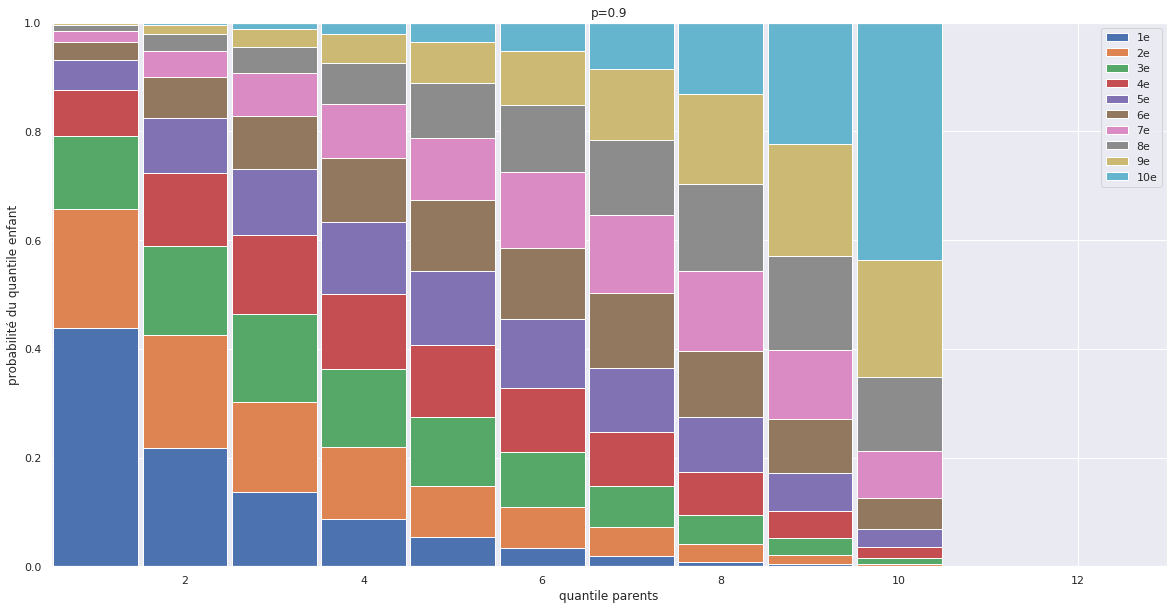

In [81]:
sample = OCR.compute_quantiles(y_child, y_parent, 10)
cd = OCR.conditional_distributions(sample, 10)
OCR.plot_conditional_distributions(pj, cd, 10)

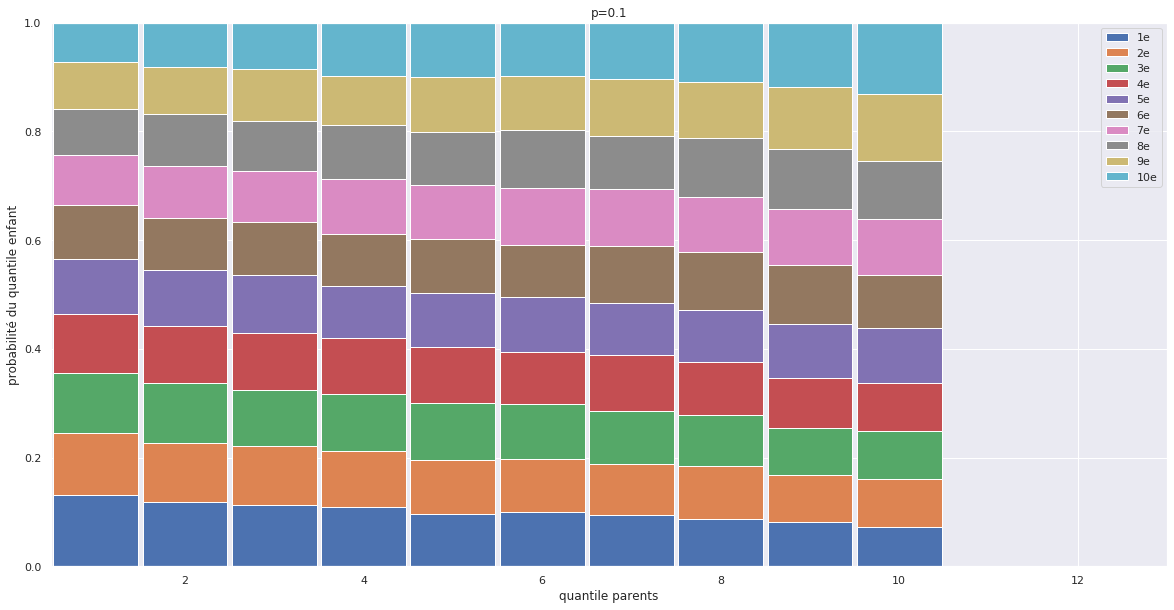

In [82]:
pj = 0.1

y_child = np.exp(pj*ln_y_parent + epsilon)
y_parent = np.exp(ln_y_parent)

sample = OCR.compute_quantiles(y_child, y_parent, 10)
cd = OCR.conditional_distributions(sample, 10)
OCR.plot_conditional_distributions(pj, cd, 10)

* Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer(nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.

In [83]:
sample = []

* Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la Wold Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution.

In [84]:
df_pop = pd.concat([df]*500, ignore_index=True)

* Pour chaque ci_child et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes ci_parent conformément aux distributions trouvées précédemment. Par exemple, si ci_parent=8 et ci_child=5, pj = 0.9) = 0.03 , alors vous assignerez la classe ci_parent= 8 à 15 des 500 individus du pays j ayant ci_child=5 , car 500*0.03 = 15.

In [85]:
df_pop.sort_values(by=['country', 'quantile'], inplace= True)
df_pop.reset_index(drop=True, inplace = True)

if not(pth.isfile('./Data/ci_parent.csv')):
    y_parent = np.exp(ln_y_parent)
    ci_parent = []

    for pays in df['country'].unique():
        print('Debut pour le pays : ' + pays)
        df_pays = df[df['country'] == pays]
        #df_pays_pop = df_pop[df_pop['country'] == pays]
        pj = df_pays['CoefElasticity'].unique()[0]

        print('Debut du calcul de la répartition')
        y_child = np.exp(pj*ln_y_parent + epsilon)

        sample = OCR.compute_quantiles(y_child, y_parent, nb_quantiles)
        cd = OCR.conditional_distributions(sample, nb_quantiles)
        print('Fin du calcul de la répartition')

        print('Création de la liste ci_parent')
        for i, centiles in enumerate(cd):
            frac, results = np.modf(500 * centiles)
            remainder = int(500 - results.sum())

            indices = np.argsort(frac)[::-1]
            results[indices[0:remainder]] += 1

            for j, nombre in enumerate(results): 
                ci_parent = np.append(ci_parent, np.full((1, nombre.astype(int)), j+1))

        print('Fin de la création de la liste ci_parent')

    ci_parent = pd.DataFrame(ci_parent, columns=['ci_parent'])
    ci_parent.to_csv('./Data/ci_parent.csv', index=False)
else:
    ci_parent = pd.read_csv('./Data/ci_parent.csv')

In [86]:
df_pop['ci_parent'] = ci_parent

## Mission 4

## ANOVA avec nos pays selectionnés

### Préparation des données

In [87]:
df_small = df[df['country name'].isin(pays)][['country', 'income']]

### Calcul du revenu moyen par pays et le revenu moyen total

In [88]:
df_mean = df[['country', 'income']].groupby('country').mean()
mean = df['income'].mean()

### Calcul du SST

In [89]:
SST = ((df.income - mean) ** 2).sum()
f'La Somme Totale des Erreurs est de {SST:0.2f}'

'La Somme Totale des Erreurs est de 1002128021314.25'

### Calcul du SSC

In [90]:
SSC = ((df_mean - mean) ** 2).sum()

### Calcul de SSE

In [91]:
SSE = 0
residu = []

for p in df['country'].unique():
    error = df[df['country'] == p].income - df_mean.loc[p].income
    residu.append(error.values)
    SSE += ((error ** 2).sum() / 100)

### Calcul de MSC

In [92]:
(df[df['country'] == p].income - df_mean.loc[p].income)**2

11299    6.083709e+04
11300    5.525668e+04
11301    5.203386e+04
11302    4.942731e+04
11303    4.734194e+04
             ...     
11394    2.858049e+05
11395    4.042001e+05
11396    6.111977e+05
11397    1.021286e+06
11398    3.869508e+06
Name: income, Length: 100, dtype: float64

In [93]:
df_colums = len(df['country'].unique()) - 1
MSC = SSC / df_colums

### Calcul de MSE

In [94]:
df_error = len(df) - len(df['country'].unique())
MSE = SSE / df_error

### Calcul de F

In [95]:
F = MSC / MSE

### Calcul de la p-value du Facteur F

In [96]:
#p = 1-ncf(F, df_colums, df_error)

In [97]:
F

income    98.349963
dtype: float64

In [98]:
p

'COD'

Ensuite, nous allons tester la distribution normale des revenus

In [99]:
#df['income'] = np.log(np.abs(df['income']))

In [100]:
df['income']

0         728.89795
1         916.66235
2        1010.91600
3        1086.90780
4        1132.69970
            ...    
11394     810.62330
11395     911.78340
11396    1057.80740
11397    1286.60290
11398    2243.12260
Name: income, Length: 11399, dtype: float64

In [101]:
anova_country = smf.ols("income~country", data=df).fit()
print(anova_country.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.35
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:26:52   Log-Likelihood:            -1.1652e+05
No. Observations:               11399   AIC:                         2.333e+05
Df Residuals:                   11285   BIC:                         2.341e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299    668.885      4.

In [102]:
sm.stats.anova_lm(anova_country)

,df,sum_sq,mean_sq,F,PR(>F)
country,113.0,4.972283e+11,4.400251e+09,98.349886,0.0
Residual,11285.0,5.048997e+11,4.474078e+07,NaN,NaN


In [103]:
# Shapiro-Wilk Test - normality test
stat, p = shapiro(df['income'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.596, p=0.000
Sample does not look Gaussian (reject H0)


/home/heidoji/DataScience/Anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [104]:
stat, p = normaltest(df['income'])

In [105]:
p

0.0

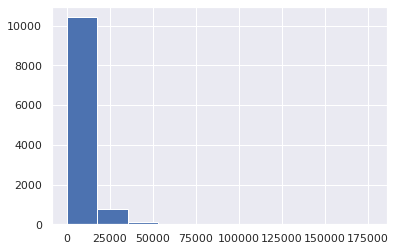

In [106]:
df['income'].hist()

In [107]:
#df['income'] = (df['income'] - df['income'].mean()) / df['income'].std()

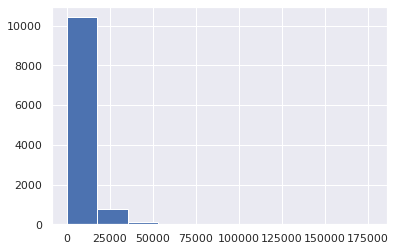

In [108]:
df['income'].hist()

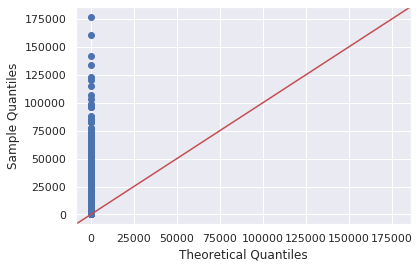

In [109]:
fig = sm.qqplot(df['income'], line='45')
plt.show()

In [110]:
from scipy.stats import bartlett

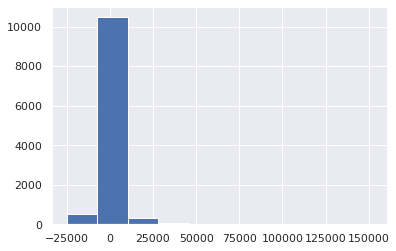

In [111]:
anova_country.resid.hist()

In [112]:
residus = (anova_country.resid - anova_country.resid.mean()) / anova_country.resid.std()

In [113]:
residus

0       -0.340454
1       -0.312243
2       -0.298081
3       -0.286664
4       -0.279783
           ...   
11394    0.080324
11395    0.095523
11396    0.117463
11397    0.151840
11398    0.295556
Length: 11399, dtype: float64

In [114]:
# Shapiro-Wilk Test - normality test
stat, p = shapiro(residus.sort_values())
print('Statistics=%.3f, p=%.8f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.559, p=0.00000000
Sample does not look Gaussian (reject H0)


/home/heidoji/DataScience/Anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


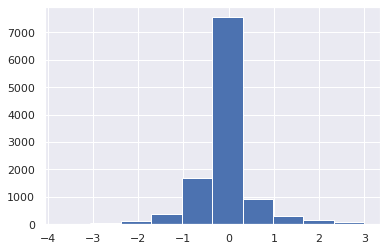

In [115]:
residus.sort_values()[:-150].hist()

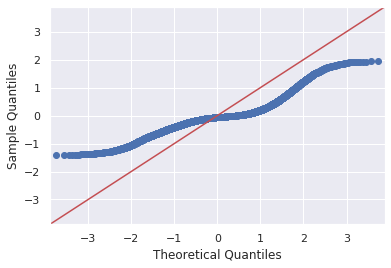

In [116]:
fig = sm.qqplot(residus.sort_values()[300:-300], line='45')
plt.show()

In [117]:
df

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,country name,Mean Gini,CoefElasticity
0,ALB,2008.0,1.0,100.0,728.89795,0.031430,7297.00000,Albania,31.7125,0.815874
1,ALB,2008.0,2.0,100.0,916.66235,0.031430,7297.00000,Albania,31.7125,0.815874
2,ALB,2008.0,3.0,100.0,1010.91600,0.031430,7297.00000,Albania,31.7125,0.815874
3,ALB,2008.0,4.0,100.0,1086.90780,0.031430,7297.00000,Albania,31.7125,0.815874
4,ALB,2008.0,5.0,100.0,1132.69970,0.031430,7297.00000,Albania,31.7125,0.815874
...,...,...,...,...,...,...,...,...,...,...
11394,COD,2008.0,96.0,100.0,810.62330,0.624749,303.19305,"Congo, Dem. Rep.",42.1500,0.707703
11395,COD,2008.0,97.0,100.0,911.78340,0.624749,303.19305,"Congo, Dem. Rep.",42.1500,0.707703
11396,COD,2008.0,98.0,100.0,1057.80740,0.624749,303.19305,"Congo, Dem. Rep.",42.1500,0.707703
11397,COD,2008.0,99.0,100.0,1286.60290,0.624749,303.19305,"Congo, Dem. Rep.",42.1500,0.707703


Nous voyons que l'ensemble des revenus de toutes les pays ne proviennent pas d'une même population.

- Box Plot ANOVA (revenus = f(pays)) + outputs sur les hypothèses (non vérifiées) et conclure sur la robustesse de l'ANOVA vu les fréquences importantes des populations 

Régressions linéaires  (exemples d'itérations ) + validation ( en s'assurant d'analyser les résidus (les graphes des résidus , QQ plot et tests d'ajustements normalité avec Shapiro Wilk , Kolmogrorov etc.))

      1- income =f(gdppp + gini). Analyse des 

      2- log(income) = f(log(gdpp) + gini)

      3- income = f(gdppp)+gini +c_i_parent

### Regression Linéaire Multiple

#### Calcul du revenu à partir du gdpppp et du coefficient de Gini

###### Regression sans log

In [118]:
df.rename(columns={'Mean Gini' : 'Gini'}, inplace=True)

Nous allons tester les variables indépendantes avec la variable dépendantes à travers une régression linéaire simple

Regression Linéaire simple avec GDP PPP

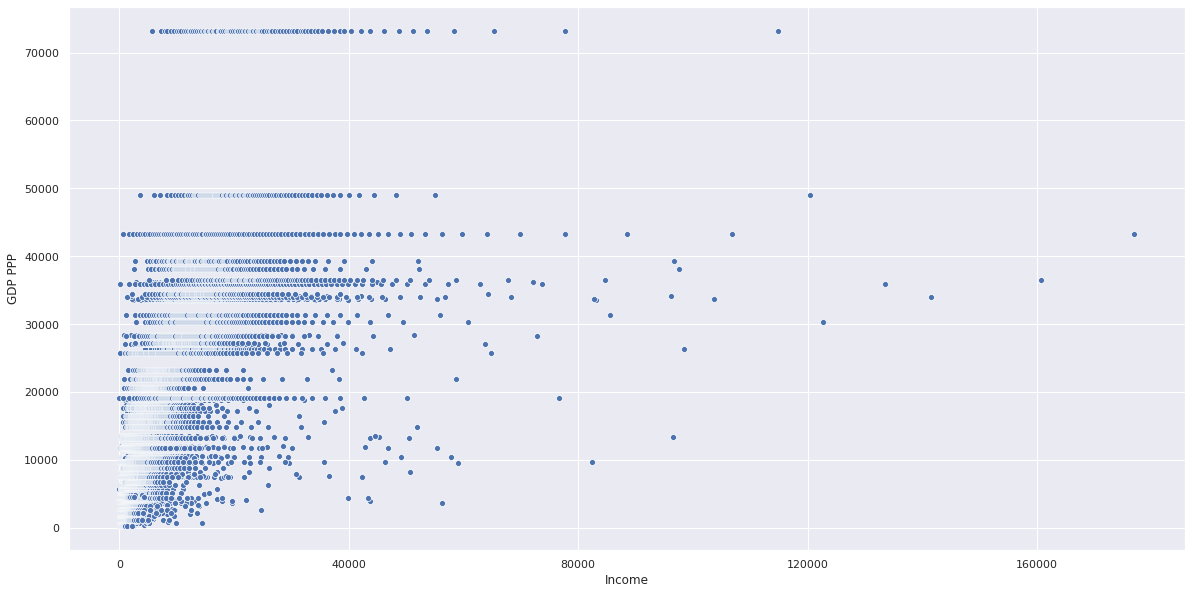

In [119]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="income", y="gdpppp", data=df)
ax.set(xlabel='Income', ylabel='GDP PPP')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [120]:
df['income'].corr(df['gdpppp'], method='pearson')

0.6696000250303608

In [121]:
X = df.loc[:, 'gdpppp'].values
y = df.loc[:, 'income'].values

In [122]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.451 +/- 0.009
Test accuracy : 0.443 +/- 0.036


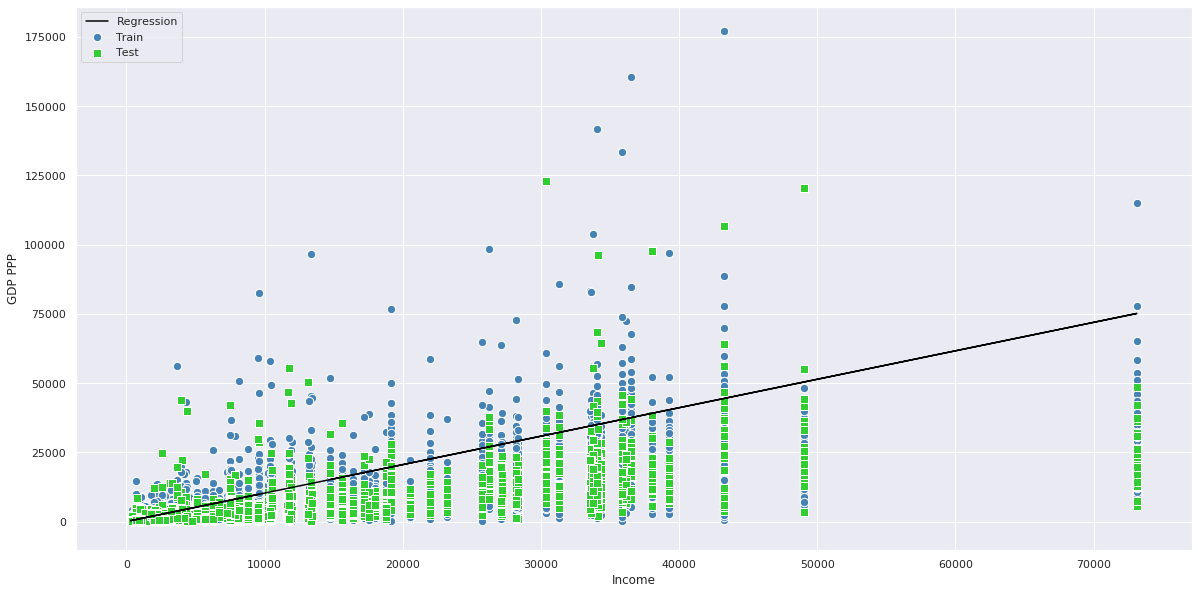

In [162]:
y_train_pred = slr_mean.predict(X_train.reshape(-1, 1))
y_test_pred = slr_mean.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('GDP PPP')
plt.show()

In [160]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.453
Test accuracy : 0.431 


In [161]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 142814542.102
MSE Test : 155128815.044


Regression Linéaire avec L'indice de Gini

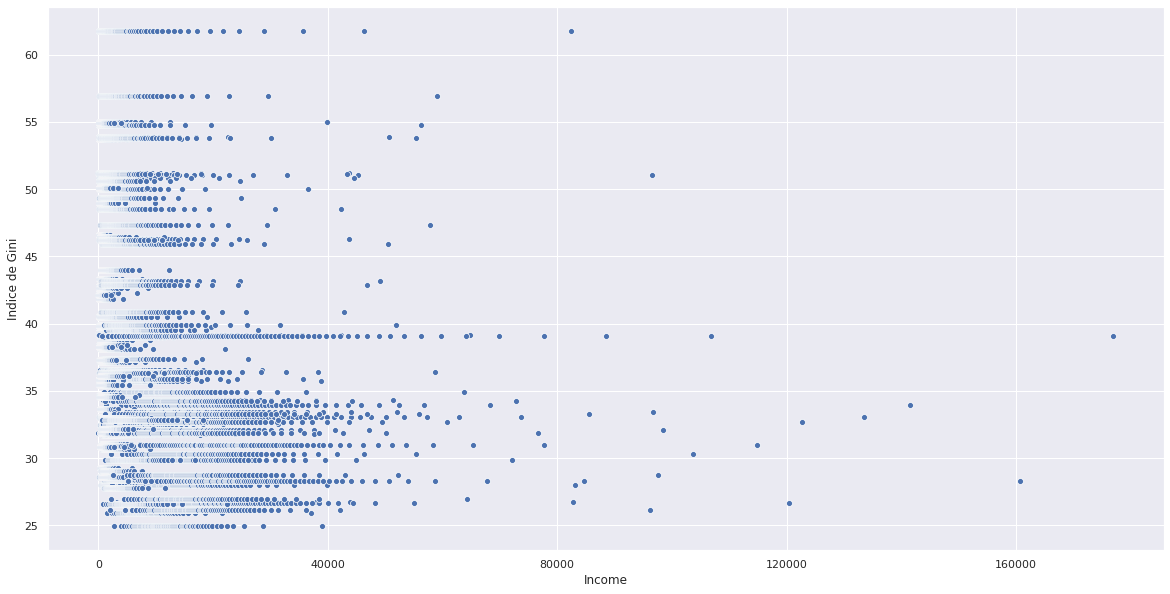

In [163]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="income", y="Gini", data=df)
ax.set(xlabel='Income', ylabel='Indice de Gini')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [164]:
df['income'].corr(df['Gini'], method='pearson')

-0.2719641779123707

Nous n'avons pas de corrélation entre la variable Gini et le revenu, ce qui peut poser problème pour la performance de la régression linéaire

In [165]:
X = df.loc[:, 'Gini'].values

In [166]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.074 +/- 0.002
Test accuracy : 0.075 +/- 0.008


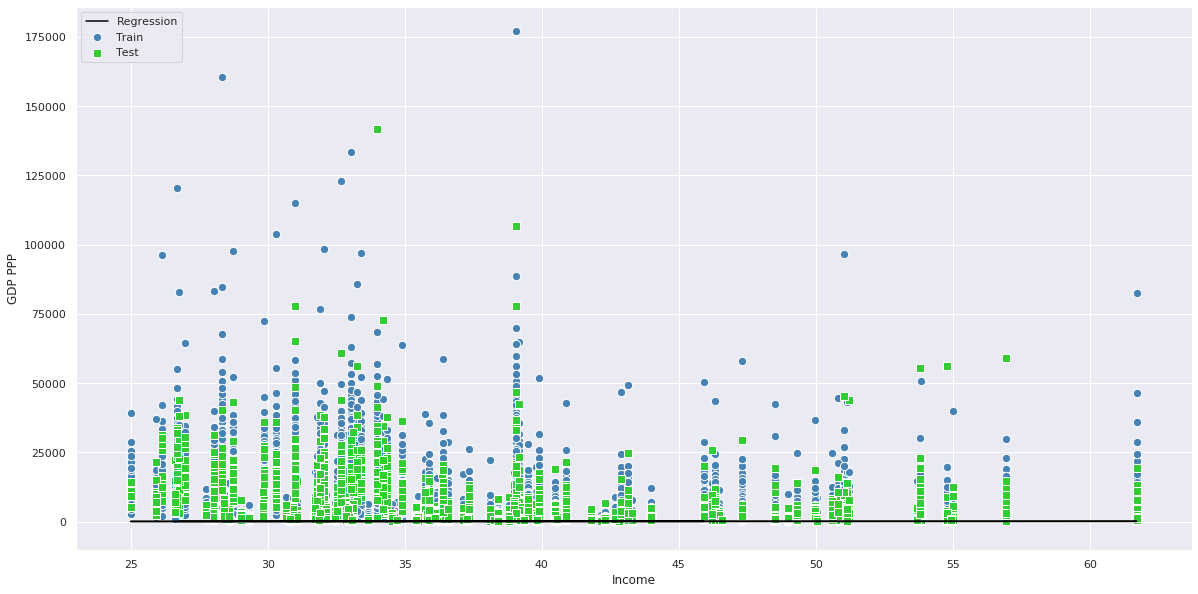

In [167]:
y_train_pred = slr_mean.predict(X_train.reshape(-1, 1))
y_test_pred = slr_mean.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('GDP PPP')
plt.show()

In [168]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.076
Test accuracy : 0.064 


In [169]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 126309962.603
MSE Test : 113241254.468


Sans surprise, le coefficient de détermination R² est très faible, avec une MSE très élevée.
Ainsi, une régression linéaire multiple avec les deux varaibles sera moins performantes qu'une régression linéaire simple avec le GDP PPP

###### Regression avec log

Nous allons tester les variables indépendantes avec la variable dépendantes à travers une régression linéaire simple

Regression Linéaire simple avec GDP PPP

In [175]:
df['log_income'] = np.log(df.loc[:, 'income'])
df['log_gdpppp'] = np.log(df.loc[:, 'gdpppp'])
df['log_gini'] = np.log(df.loc[:, 'Gini'])

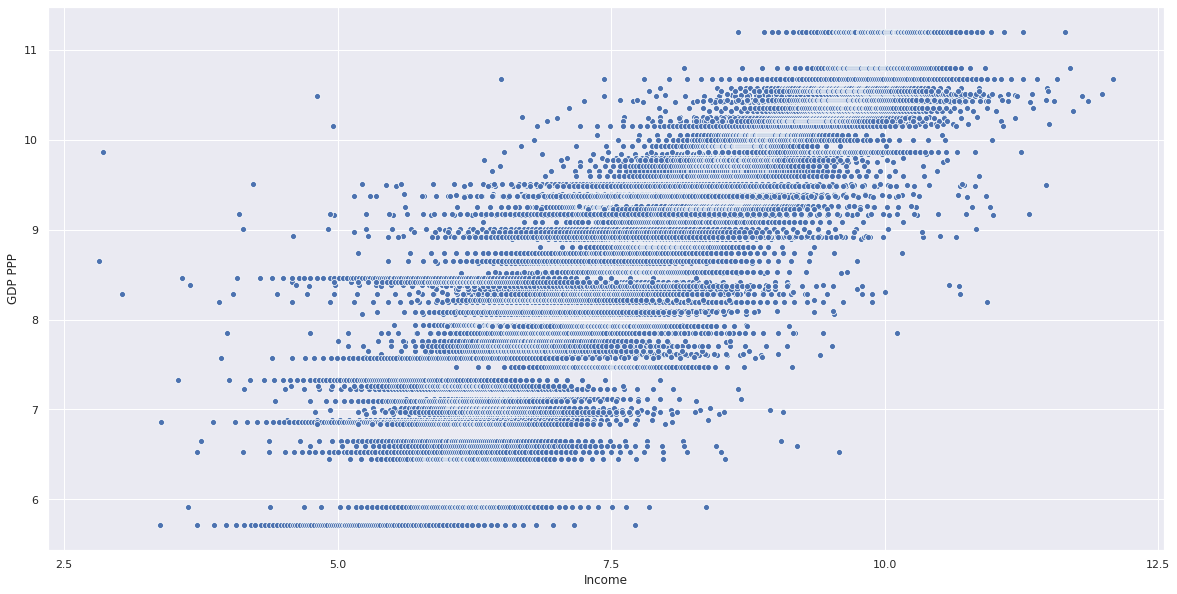

In [173]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="log_income", y="log_gdpppp", data=df)
ax.set(xlabel='Income', ylabel='GDP PPP')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [174]:
np.log(df['gdpppp']).corr(np.log(df['income']), method='pearson')

0.8034518696962291

Nous avons un coefficient de correlation élevée entre les deux variables qui montrent une relation linéaire entre les deux

Nous allons également vérifier si la performance de la régression avec la moyenne du l'income

In [198]:
data = list(zip(np.log(df.groupby('country').mean().income), np.log(df.groupby('country').mean().Gini), np.log(df.groupby('country').mean().gdpppp)))
df_mean = pd.DataFrame(data, columns=['Mean', 'Gini', 'Gdpppp'])

In [179]:
np.log(df_mean['Gdpppp']).corr(np.log(df_mean['Mean']), method='pearson')

0.9334167242766025

Nous remarquons que nous avons une corrélation plus forte en utilisant la moyenne

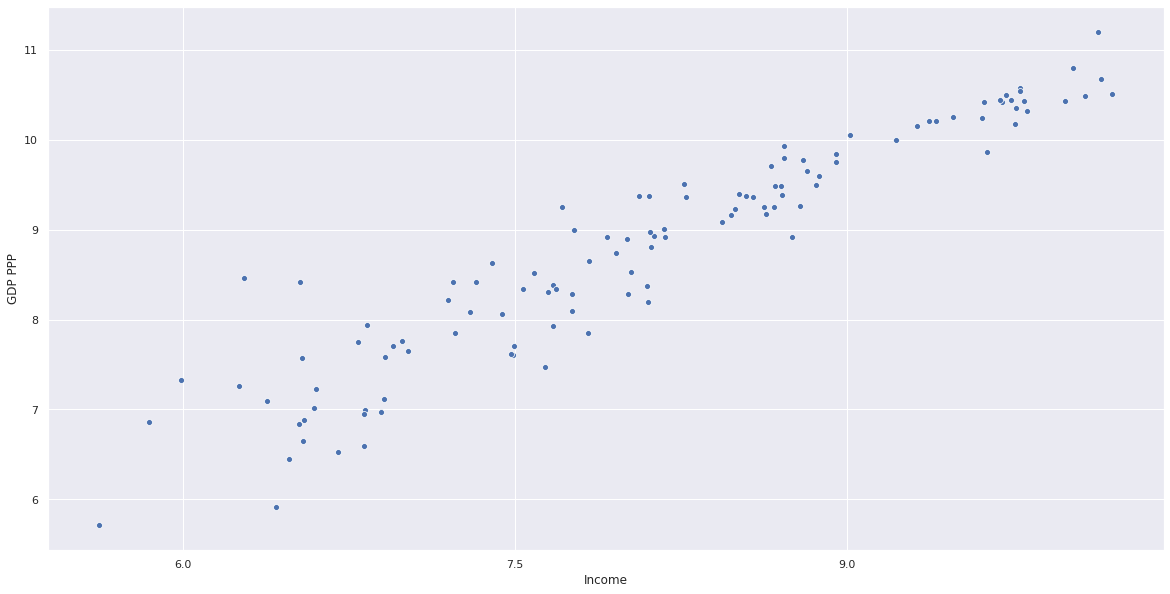

In [180]:
sns.set()

fig, axes = plt.subplots(figsize = (20, 10))
ax = sns.scatterplot(x="Mean", y="Gdpppp", data=df_mean)
ax.set(xlabel='Income', ylabel='GDP PPP')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [182]:
X = df.loc[:, 'log_gdpppp'].values
y = df.loc[:, 'log_income'].values

In [183]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.646 +/- 0.001
Test accuracy : 0.642 +/- 0.006


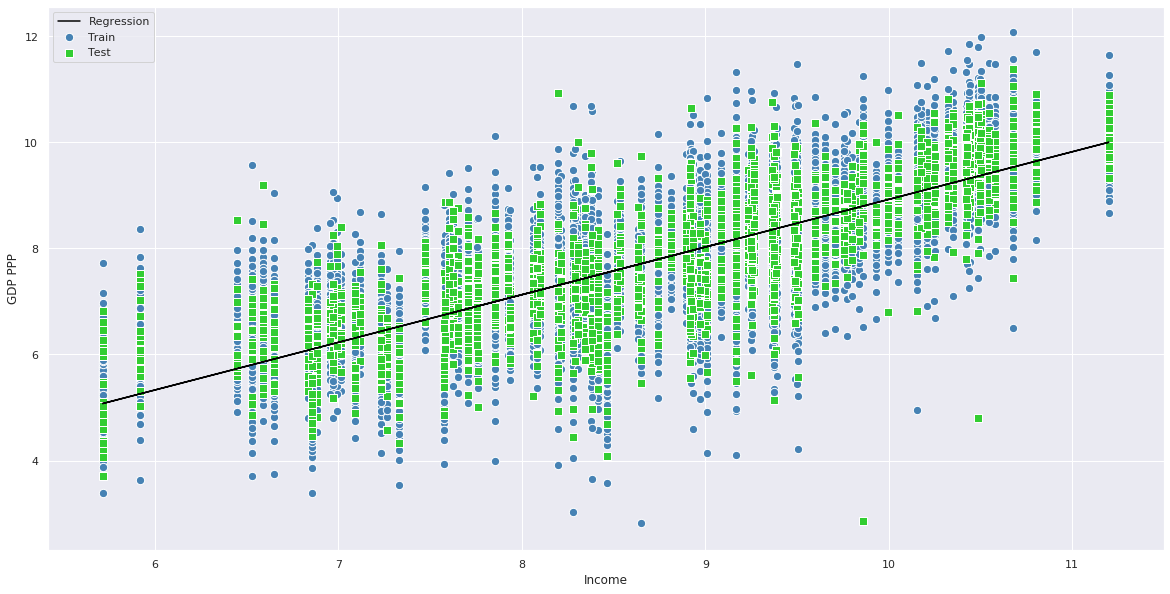

In [185]:
y_train_pred = slr.predict(X_train.reshape(-1, 1))
y_test_pred = slr.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('GDP PPP')
plt.show()

In [186]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.646
Test accuracy : 0.644 


In [187]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 0.677
MSE Test : 0.669


Nous constatons, avec l'utilisation de d'une fonction log, un meilleur coefficient de détermination

In [188]:
X = df.loc[:, 'log_gini'].values

In [189]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.140 +/- 0.002
Test accuracy : 0.137 +/- 0.008


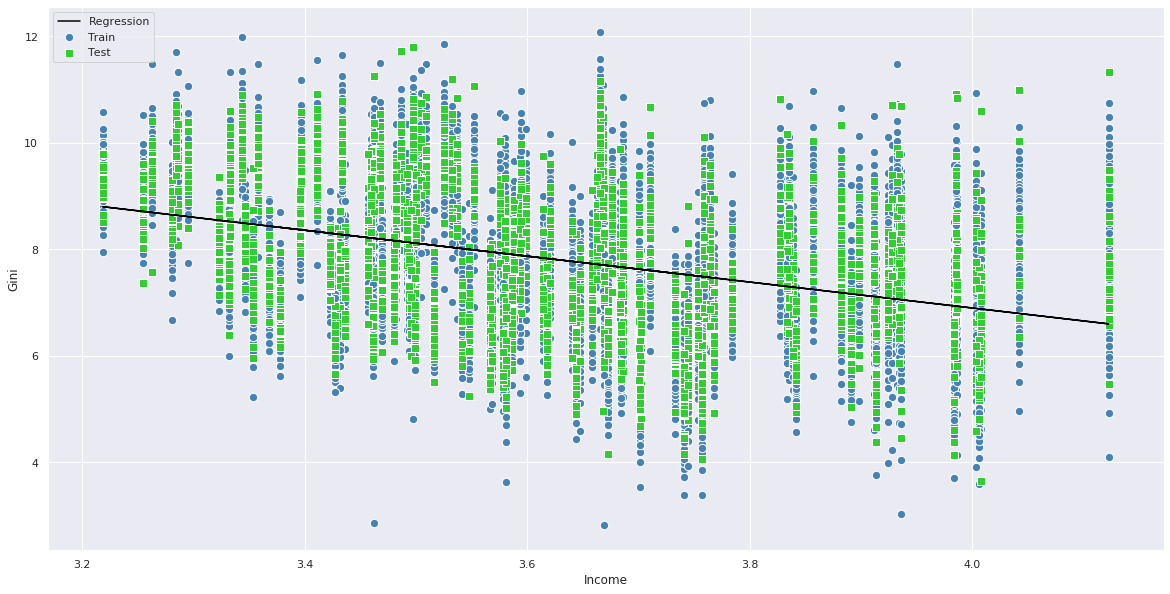

In [191]:
y_train_pred = slr.predict(X_train.reshape(-1, 1))
y_test_pred = slr.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('Gini')
plt.show()

In [193]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.136
Test accuracy : 0.149 


In [194]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 1.641
MSE Test : 1.639


Nous constatons une faible corrélation entre le revenu et le coefficient de Gini

Regression Linéaire avec la moyenne du revenu

In [199]:
X = df_mean.loc[:, 'Gdpppp'].values
y = df_mean.loc[:, 'Mean'].values

In [200]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.892 +/- 0.011
Test accuracy : 0.877 +/- 0.046


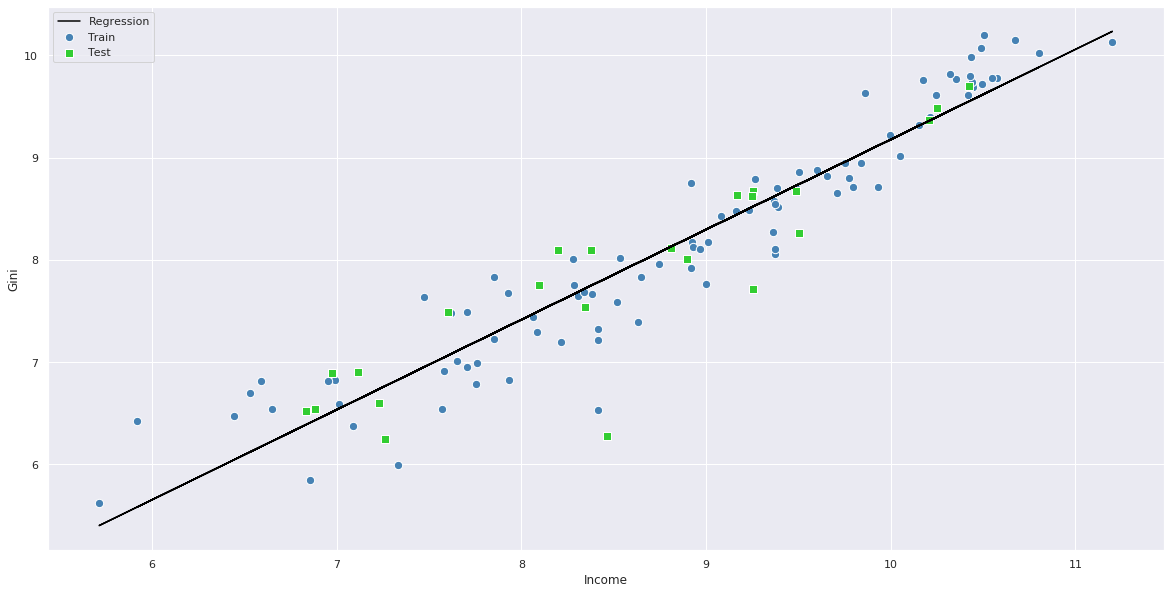

In [201]:
y_train_pred = slr.predict(X_train.reshape(-1, 1))
y_test_pred = slr.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('Gini')
plt.show()

In [202]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.906
Test accuracy : 0.803 


In [203]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 0.128
MSE Test : 0.201


Nous avons une meilleur performance en utilisant la moyenne des revenus.

In [204]:
X = df_mean.loc[:, 'Gini'].values

In [205]:
slr = LinearRegression()
scores_train = []
scores_test = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    slr.fit(X_train.reshape(-1, 1), y_train)
    score_train = slr.score(X_train.reshape(-1, 1), y_train)
    score_test = slr.score(X_test.reshape(-1, 1), y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
    
print('Train accuracy : %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
print('Test accuracy : %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))

Train accuracy : 0.120 +/- 0.017
Test accuracy : -0.029 +/- 0.329


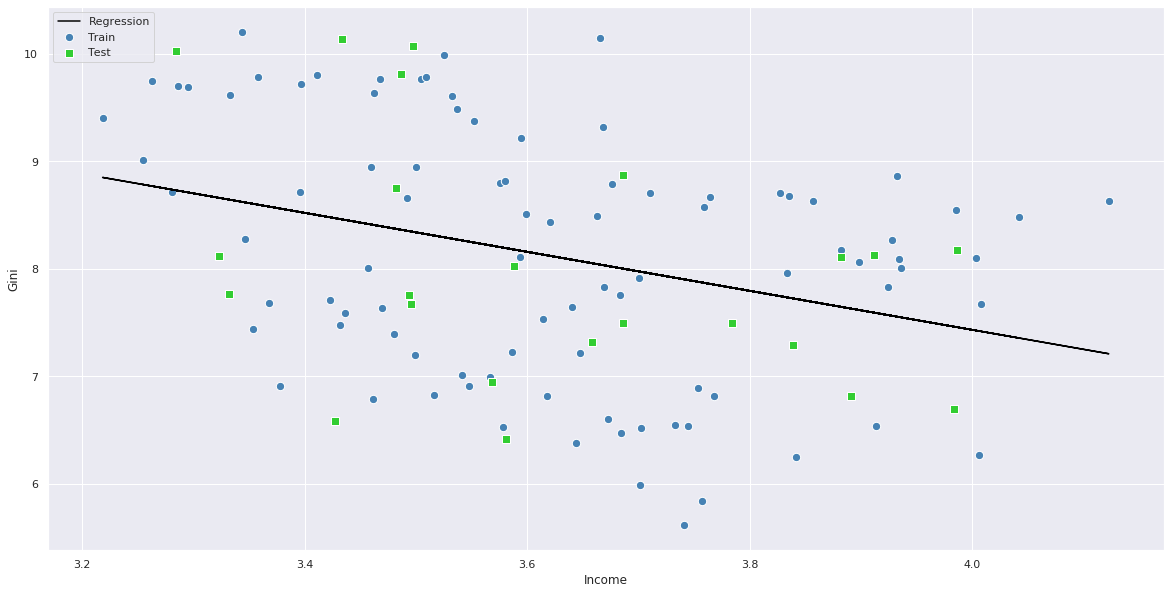

In [206]:
y_train_pred = slr.predict(X_train.reshape(-1, 1))
y_test_pred = slr.predict(X_test.reshape(-1, 1))

fig, axes = plt.subplots(figsize = (20, 10))

plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, marker='o', label='Train')
plt.scatter(X_test, y_test, c='limegreen', edgecolor='white', s=70, marker='s', label='Test')
plt.plot(X_train, y_train_pred, c='black', label='Regression')
plt.legend(loc = 'upper left')
plt.xlabel('Income')
plt.ylabel('Gini')
plt.show()

In [207]:
print('Train accuracy : %.3f' % (score_train))
print('Test accuracy : %.3f ' % (score_test))

Train accuracy : 0.107
Test accuracy : 0.143 


In [208]:
print('MSE Train : %.3f' % mean_squared_error(y_train, y_train_pred))
print('MSE Test : %.3f' % mean_squared_error(y_test, y_test_pred))

MSE Train : 1.189
MSE Test : 1.043


Nous avons une moins bonne performance avec le Gini, en utilisant la moyenne des revenus

In [123]:
reg_multi = smf.ols('income~gdpppp+Gini', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4631.
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:26:53   Log-Likelihood:            -1.1704e+05
No. Observations:               11399   AIC:                         2.341e+05
Df Residuals:                   11396   BIC:                         2.341e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.9781    371.472     -0.140      0.8

In [124]:
df['Gini_log'] = np.log(df['Gini'])
df['gdpppp_log'] = np.log(df['gdpppp'])
df['income_log'] = np.log(df['income'])

In [125]:
reg_multi = smf.ols('income_log~gdpppp_log+Gini_log', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                 1.081e+04
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:26:53   Log-Likelihood:                -13788.
No. Observations:               11399   AIC:                         2.758e+04
Df Residuals:                   11396   BIC:                         2.760e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7685      0.170     16.290      0.0

Nous constatons que nous avons un meilleur coefficient de determination en y appliquant une opération non linéaire, ici un transformation avec un logarithme néperien.

##### Analyse des résultats

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [126]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [127]:
n = df.shape[0]
p = 3

##### Calcul des valeurs de levier

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [128]:
df['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

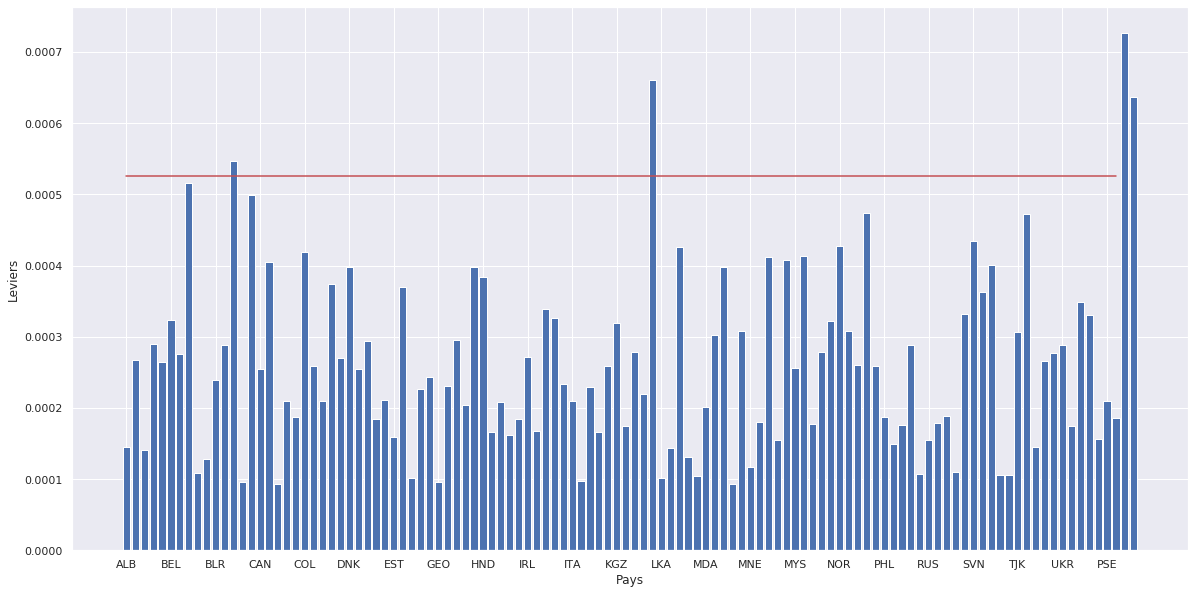

In [129]:
plt.figure(figsize=(20,10))
plt.bar(df['country'], df['levier'])
plt.xticks(np.arange(0, 111, step=5))
plt.xlabel('Pays')
plt.ylabel('Leviers')
plt.plot([0, 111], [seuil_levier, seuil_levier], color='r')
plt.show()

In [130]:
df.groupby('country name').mean()[df.groupby('country name').mean()['levier'] > seuil_levier].levier

country name
Brazil              0.000547
Congo, Dem. Rep.    0.000637
Liberia             0.000660
South Africa        0.000727
Name: levier, dtype: float64

##### Calculez les résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [131]:
df['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

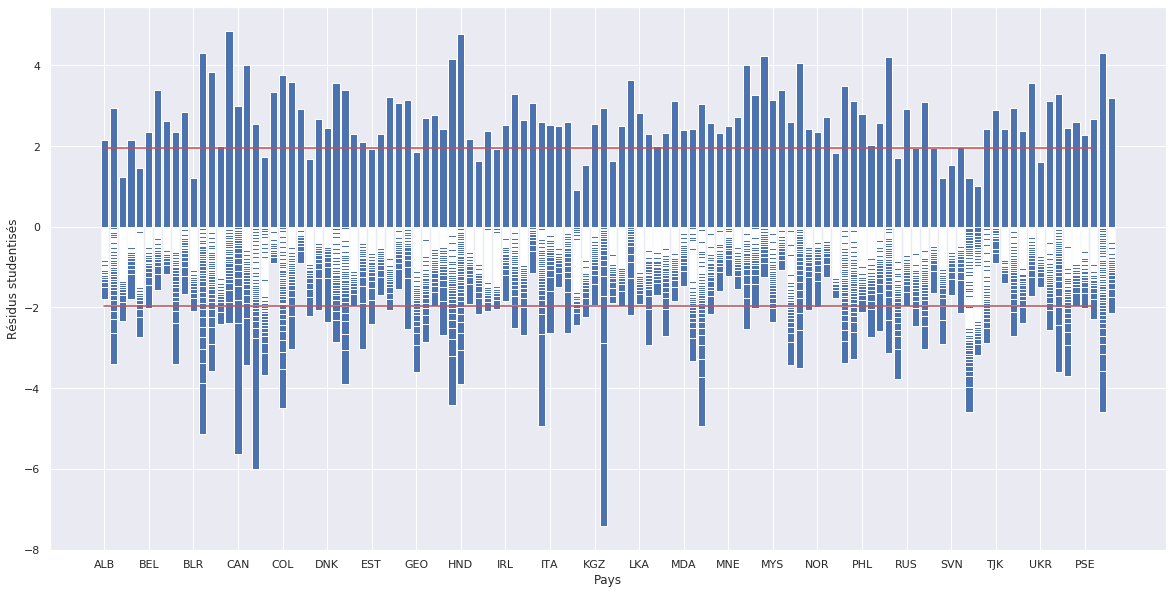

In [132]:
plt.figure(figsize=(20,10))
plt.bar(df['country'], df['rstudent'])
plt.xticks(np.arange(0, 111, step=5))
plt.xlabel('Pays')
plt.ylabel('Résidus studentisés')
plt.plot([0, 111], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 111], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

##### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [133]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

In [134]:
df['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

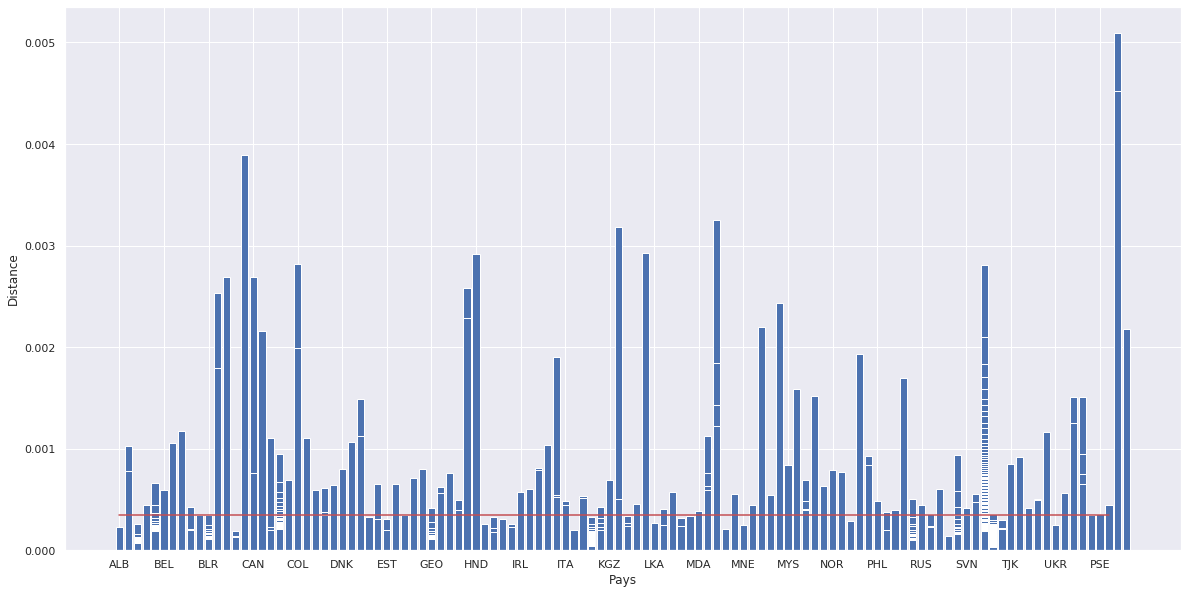

In [135]:
plt.figure(figsize=(20,10))
plt.bar(df['country'], df['dcooks'])
plt.xticks(np.arange(0, 111, step=5))
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.plot([0, 111], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [136]:
df_country = df[df['country'].isin(['COD', 'FJI', 'LBR', 'ZAF'])]
df_country.loc[df_country['dcooks'] > seuil_dcook, 'country name'].unique()

array(['Liberia', 'South Africa', 'Congo, Dem. Rep.'], dtype=object)

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

In [137]:
df_wo = df[~df['country'].isin(['COD', 'FJI', 'LBR', 'ZAF'])]

##### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [138]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1420691464903054, 1.1420691464903057]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

##### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [139]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 9.911280645048609e-113


##### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [140]:
shapiro(reg_multi.resid.sample(111))

(0.9877043962478638, 0.4095724821090698)

In [141]:
reg_multi = smf.ols('income_log~gdpppp_log+Gini_log', data=df_wo).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 1.032e+04
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:27:53   Log-Likelihood:                -13196.
No. Observations:               10999   AIC:                         2.640e+04
Df Residuals:                   10996   BIC:                         2.642e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3568      0.177     13.280      0.0

In [142]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1683360573167376, 1.1683360573167372]

In [143]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.1305202793954957e-105


In [144]:
shapiro(reg_multi.resid.sample(107))

(0.9896102547645569, 0.5852882266044617)

In [145]:
df_pop.rename(columns={'Mean Gini' : 'Gini'}, inplace=True)
reg_multi = smf.ols('income~gdpppp+Gini+ci_parent', data=df_pop).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 1.710e+06
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:27:55   Log-Likelihood:            -5.6848e+07
No. Observations:             5550000   AIC:                         1.137e+08
Df Residuals:                 5549996   BIC:                         1.137e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2734.2665     17.834   -153.318      0.0

In [146]:
df_pop['Gini_log'] = np.log(df_pop['Gini'])
df_pop['gdpppp_log'] = np.log(df_pop['gdpppp'])
df_pop['income_log'] = np.log(df_pop['income'])
df_pop['ci_parent_log'] = np.log(df_pop['ci_parent'])

In [147]:
reg_multi = smf.ols('income_log~gdpppp_log+Gini_log+ci_parent_log', data=df_pop).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 4.307e+06
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:27:56   Log-Likelihood:            -6.3529e+06
No. Observations:             5550000   AIC:                         1.271e+07
Df Residuals:                 5549996   BIC:                         1.271e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6887      0.008    223.422